In [110]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

from collections import defaultdict

import yfinance as yf
from torchvision.transforms import ToTensor

In [111]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

tqdm.pandas()


In [112]:
pl.seed_everything(42)


Global seed set to 42


42

In [72]:
ak = pd.read_csv("goog_max.csv")

In [74]:
ak["previous"] = ak.shift(1)["Close"]

In [77]:
ak

,Date,Open,High,Low,Close,Adj Close,Volume,previous
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216,0.000000
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,2.499133
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,2.697639
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,2.724787
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,2.611960
...,...,...,...,...,...,...,...,...
4630,2023-01-10,86.720001,89.474998,86.699997,89.239998,89.239998,22855600,88.800003
4631,2023-01-11,90.059998,92.449997,89.739998,92.260002,92.260002,25998800,89.239998
4632,2023-01-12,92.400002,92.620003,90.570000,91.910004,91.910004,22754200,92.260002
4633,2023-01-13,91.528000,92.980003,90.930000,92.800003,92.800003,18617800,91.910004


In [78]:
rows = []
for i in range(ak.shape[0]):
    row_data= dict(
    Open = ak.Open[i],
    High = ak.High[i],
    #Close = ak.Close[i],
    Low = ak.Low[i],
    Volume = ak.Volume[i],
    Previous = ak.previous[i],
    last_difference = ak.Close[i] - ak.previous[i]
    )
    rows.append(row_data)
features = pd.DataFrame(rows)

In [79]:
features.shape

(4635, 6)

In [80]:
features

,Open,High,Low,Volume,Previous,last_difference
0,2.490664,2.591785,2.390042,897427216,0.000000,2.499133
1,2.515820,2.716817,2.503118,458857488,2.499133,0.198506
2,2.758411,2.826406,2.716070,366857939,2.697639,0.027148
3,2.770615,2.779581,2.579581,306396159,2.724787,-0.112827
4,2.614201,2.689918,2.587302,184645512,2.611960,0.028144
...,...,...,...,...,...,...
4630,86.720001,89.474998,86.699997,22855600,88.800003,0.439995
4631,90.059998,92.449997,89.739998,25998800,89.239998,3.020004
4632,92.400002,92.620003,90.570000,22754200,92.260002,-0.349998
4633,91.528000,92.980003,90.930000,18617800,91.910004,0.889999


In [81]:
rows = []
for i in range(ak.shape[0]):
    row_data= dict(
    Close = ak.Close[i]
    )
    rows.append(row_data)
labels = pd.DataFrame(rows)

In [82]:
labels

,Close
0,2.499133
1,2.697639
2,2.724787
3,2.611960
4,2.640104
...,...
4630,89.239998
4631,92.260002
4632,91.910004
4633,92.800003


In [83]:
features

,Open,High,Low,Volume,Previous,last_difference
0,2.490664,2.591785,2.390042,897427216,0.000000,2.499133
1,2.515820,2.716817,2.503118,458857488,2.499133,0.198506
2,2.758411,2.826406,2.716070,366857939,2.697639,0.027148
3,2.770615,2.779581,2.579581,306396159,2.724787,-0.112827
4,2.614201,2.689918,2.587302,184645512,2.611960,0.028144
...,...,...,...,...,...,...
4630,86.720001,89.474998,86.699997,22855600,88.800003,0.439995
4631,90.059998,92.449997,89.739998,25998800,89.239998,3.020004
4632,92.400002,92.620003,90.570000,22754200,92.260002,-0.349998
4633,91.528000,92.980003,90.930000,18617800,91.910004,0.889999


In [84]:
train_size = int((len(features))*.9)
test_size = int((len(features))*.1)


In [85]:
labels

,Close
0,2.499133
1,2.697639
2,2.724787
3,2.611960
4,2.640104
...,...
4630,89.239998
4631,92.260002
4632,91.910004
4633,92.800003


In [86]:
train_size,test_size

(4171, 463)

In [87]:
train_x,test_x = features[:train_size],  features[train_size:]
train_y,test_y = labels[:train_size],  labels[train_size:]


In [88]:
train_y

,Close
0,2.499133
1,2.697639
2,2.724787
3,2.611960
4,2.640104
...,...
4166,102.635002
4167,102.751503
4168,105.738503
4169,103.096001


In [89]:
scaler1 = MinMaxScaler(feature_range=(0,1))
train_x= pd.DataFrame(
        scaler1.fit_transform(train_x),
        index = train_x.index,
        columns = train_x.columns)

In [90]:
train_y= pd.DataFrame(
        scaler1.fit_transform(train_y),
        index = train_y.index,
        columns = train_y.columns)

In [91]:
test_x= pd.DataFrame(
        scaler1.fit_transform(test_x),
        index = test_x.index,
        columns = test_x.columns)


In [92]:
test_y= pd.DataFrame(
        scaler1.fit_transform(test_y),
        index = test_y.index,
        columns = test_y.columns)


In [93]:
train_x

,Open,High,Low,Volume,Previous,last_difference
0,0.000195,0.000550,0.000000,0.543577,0.000000,0.666940
1,0.000438,0.001739,0.001100,0.277886,0.023485,0.501404
2,0.002782,0.002782,0.003171,0.222151,0.025350,0.489074
3,0.002900,0.002337,0.001843,0.185523,0.025605,0.479002
4,0.001389,0.001484,0.001918,0.111765,0.024545,0.489146
...,...,...,...,...,...,...
4166,0.976196,0.964491,0.972512,0.020469,0.951069,0.589761
4167,0.977047,0.963045,0.965481,0.015275,0.964474,0.495503
4168,0.978158,0.987165,0.984450,0.014917,0.965569,0.702044
4169,0.983443,0.970304,0.972376,0.020814,0.993638,0.296985


In [94]:
train_y

,Close
0,0.000079
1,0.001989
2,0.002250
3,0.001165
4,0.001436
...,...
4166,0.963623
4167,0.964744
4168,0.993486
4169,0.968059


In [144]:
test_x

,Open,High,Low,Volume,Previous,last_difference
4171,0.277898,0.299436,0.301787,0.261932,0.295073,0.563030
4172,0.275667,0.288924,0.289746,0.214483,0.314435,0.495263
4173,0.264342,0.262776,0.274356,0.229856,0.313364,0.363479
4174,0.250062,0.245690,0.262412,0.464760,0.272557,0.516035
4175,0.249904,0.249420,0.268726,0.376045,0.277749,0.487443
...,...,...,...,...,...,...
4630,0.018236,0.044622,0.048918,0.175997,0.078996,0.520525
4631,0.068572,0.090008,0.094675,0.214715,0.085541,0.647819
4632,0.103838,0.092601,0.107168,0.174748,0.130469,0.481547
4633,0.090696,0.098093,0.112587,0.123796,0.125262,0.542727


In [143]:
test_y

,Close
4171,0.314435
4172,0.313364
4173,0.272557
4174,0.277749
4175,0.274320
...,...
4630,0.085541
4631,0.130469
4632,0.125262
4633,0.138503


In [186]:
def create_sequences(feature_data: pd.DataFrame,label_data: pd.DataFrame,sequence_length):
    sequences = []
    data_size = len(feature_data)
    
    for i in range(data_size-sequence_length):
        sequence = feature_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = label_data.iloc[label_position]["Close"]
        sequences.append((sequence,label))
    return sequences

In [187]:
train_sequences = create_sequences(train_x,train_y,5)
test_sequences = create_sequences(test_x,test_y,5)

In [188]:
len(train_sequences),len(test_sequences)

(4166, 459)

In [189]:
train_sequences

[(       Open      High       Low    Volume  Previous  last_difference
  0  0.000195  0.000550  0.000000  0.543577  0.000000         0.666940
  1  0.000438  0.001739  0.001100  0.277886  0.023485         0.501404
  2  0.002782  0.002782  0.003171  0.222151  0.025350         0.489074
  3  0.002900  0.002337  0.001843  0.185523  0.025605         0.479002
  4  0.001389  0.001484  0.001918  0.111765  0.024545         0.489146,
  0.0018933248748919732),
 (       Open      High       Low    Volume  Previous  last_difference
  1  0.000438  0.001739  0.001100  0.277886  0.023485         0.501404
  2  0.002782  0.002782  0.003171  0.222151  0.025350         0.489074
  3  0.002900  0.002337  0.001843  0.185523  0.025605         0.479002
  4  0.001389  0.001484  0.001918  0.111765  0.024545         0.489146
  5  0.001386  0.001472  0.002107  0.086276  0.024809         0.490543,
  0.0014715190007399993),
 (       Open      High       Low    Volume  Previous  last_difference
  2  0.002782  0.002782

In [190]:
test_sequences

[(          Open      High       Low    Volume  Previous  last_difference
  4171  0.277898  0.299436  0.301787  0.261932  0.295073         0.563030
  4172  0.275667  0.288924  0.289746  0.214483  0.314435         0.495263
  4173  0.264342  0.262776  0.274356  0.229856  0.313364         0.363479
  4174  0.250062  0.245690  0.262412  0.464760  0.272557         0.516035
  4175  0.249904  0.249420  0.268726  0.376045  0.277749         0.487443,
  0.28500876880022696),
 (          Open      High       Low    Volume  Previous  last_difference
  4172  0.275667  0.288924  0.289746  0.214483  0.314435         0.495263
  4173  0.264342  0.262776  0.274356  0.229856  0.313364         0.363479
  4174  0.250062  0.245690  0.262412  0.464760  0.272557         0.516035
  4175  0.249904  0.249420  0.268726  0.376045  0.277749         0.487443
  4176  0.257334  0.260337  0.278623  0.231235  0.274320         0.534266,
  0.2791323798588976),
 (          Open      High       Low    Volume  Previous  last_

In [191]:
class akbankDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self,index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float())


In [192]:
train_dataset = akbankDataset(train_sequences)
test_dataset = akbankDataset(test_sequences)

In [193]:
train_dataset.__getitem__(3).items()

dict_items([('sequence', tensor([[0.0029, 0.0023, 0.0018, 0.1855, 0.0256, 0.4790],
        [0.0014, 0.0015, 0.0019, 0.1118, 0.0245, 0.4891],
        [0.0014, 0.0015, 0.0021, 0.0863, 0.0248, 0.4905],
        [0.0021, 0.0016, 0.0024, 0.0755, 0.0253, 0.4840],
        [0.0015, 0.0009, 0.0015, 0.0632, 0.0248, 0.4797]])), ('label', tensor(0.0006))])

In [194]:
class akbankPriceDataModule_normal(pl.LightningDataModule):
    def __init__(
            self,train_sequences,test_sequences,batch_size
    ):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self):
        self.train_dataset = akbankDataset(self.train_sequences)
        self.test_dataset = akbankDataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,self.batch_size,shuffle = False)
    def val_dataloader(self):
        return DataLoader(self.test_dataset,self.batch_size,shuffle = False)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,self.batch_size,shuffle = False)

In [197]:
N_EPOCHS = 200
BATCH_SIZE = 32

In [198]:
train_dataset.sequences

[(       Open      High       Low    Volume  Previous  last_difference
  0  0.000195  0.000550  0.000000  0.543577  0.000000         0.666940
  1  0.000438  0.001739  0.001100  0.277886  0.023485         0.501404
  2  0.002782  0.002782  0.003171  0.222151  0.025350         0.489074
  3  0.002900  0.002337  0.001843  0.185523  0.025605         0.479002
  4  0.001389  0.001484  0.001918  0.111765  0.024545         0.489146,
  0.0018933248748919732),
 (       Open      High       Low    Volume  Previous  last_difference
  1  0.000438  0.001739  0.001100  0.277886  0.023485         0.501404
  2  0.002782  0.002782  0.003171  0.222151  0.025350         0.489074
  3  0.002900  0.002337  0.001843  0.185523  0.025605         0.479002
  4  0.001389  0.001484  0.001918  0.111765  0.024545         0.489146
  5  0.001386  0.001472  0.002107  0.086276  0.024809         0.490543,
  0.0014715190007399993),
 (       Open      High       Low    Volume  Previous  last_difference
  2  0.002782  0.002782

In [199]:
data_module = akbankPriceDataModule_normal(train_sequences, test_sequences, batch_size = BATCH_SIZE)
data_module.setup()

In [200]:
data_module.batch_size

32

In [201]:
#test
for item in data_module.train_dataloader():
    print(item)
    break

{'sequence': tensor([[[1.9493e-04, 5.4979e-04, 0.0000e+00, 5.4358e-01, 0.0000e+00,
          6.6694e-01],
         [4.3800e-04, 1.7394e-03, 1.0997e-03, 2.7789e-01, 2.3485e-02,
          5.0140e-01],
         [2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e-01, 2.5350e-02,
          4.8907e-01],
         [2.9000e-03, 2.3366e-03, 1.8433e-03, 1.8552e-01, 2.5605e-02,
          4.7900e-01],
         [1.3886e-03, 1.4835e-03, 1.9183e-03, 1.1176e-01, 2.4545e-02,
          4.8915e-01]],

        [[4.3800e-04, 1.7394e-03, 1.0997e-03, 2.7789e-01, 2.3485e-02,
          5.0140e-01],
         [2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e-01, 2.5350e-02,
          4.8907e-01],
         [2.9000e-03, 2.3366e-03, 1.8433e-03, 1.8552e-01, 2.5605e-02,
          4.7900e-01],
         [1.3886e-03, 1.4835e-03, 1.9183e-03, 1.1176e-01, 2.4545e-02,
          4.8915e-01],
         [1.3862e-03, 1.4716e-03, 2.1073e-03, 8.6276e-02, 2.4809e-02,
          4.9054e-01]],

        [[2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e

In [202]:
class PricePredictionModel(nn.Module):
    
    def __init__(self, n_features=6, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers, # Stack LSTMs
            dropout = 0.2
                            )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1] 

        return self.regressor(out)

In [211]:
class just_GRU(nn.Module):
    
    def __init__(self, n_features=6, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden

        self.gru = nn.GRU(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers, # Stack GRUs
            dropout = 0.2
                            )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.gru.flatten_parameters()

        _, (hidden, _) = self.gru(x)
        out = hidden[-1] 

        return self.regressor(out)

In [212]:
class HybridGRU_LSTM_Model(nn.Module):
    
    def __init__(self, n_features=6, n_hidden=100, n_layers=1):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = 100,
            batch_first = True,
            num_layers = 1, #1 LSTM
            dropout = 0.2
                            )
        self.regressor = nn.Linear(n_hidden, 1)
        
        self.gru = nn.GRU(
                    input_size = 100,
                    hidden_size = 50,
                    batch_first = True,
                    num_layers = 1,  #1 GRU with dropout
                    dropout = 0.2)
        
        self.linear = nn.Linear(6,1)
        

    def forward(self, x):
        self.lstm.flatten_parameters()
        a = self.lstm(x)
        b = self.gru(a)
        out = self.linear(b,1) 
        return out
        #return self.regressor(out)

In [213]:
class akbankPricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, output = self.forward(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, output = self.forward(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
  
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, output = self.forward(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.model.parameters(), lr=0.001)

In [214]:
model = akbankPricePredictor(n_features = 6)
     

In [215]:
for item in data_module.train_dataloader():
    print(item)
    break

{'sequence': tensor([[[1.9493e-04, 5.4979e-04, 0.0000e+00, 5.4358e-01, 0.0000e+00,
          6.6694e-01],
         [4.3800e-04, 1.7394e-03, 1.0997e-03, 2.7789e-01, 2.3485e-02,
          5.0140e-01],
         [2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e-01, 2.5350e-02,
          4.8907e-01],
         [2.9000e-03, 2.3366e-03, 1.8433e-03, 1.8552e-01, 2.5605e-02,
          4.7900e-01],
         [1.3886e-03, 1.4835e-03, 1.9183e-03, 1.1176e-01, 2.4545e-02,
          4.8915e-01]],

        [[4.3800e-04, 1.7394e-03, 1.0997e-03, 2.7789e-01, 2.3485e-02,
          5.0140e-01],
         [2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e-01, 2.5350e-02,
          4.8907e-01],
         [2.9000e-03, 2.3366e-03, 1.8433e-03, 1.8552e-01, 2.5605e-02,
          4.7900e-01],
         [1.3886e-03, 1.4835e-03, 1.9183e-03, 1.1176e-01, 2.4545e-02,
          4.8915e-01],
         [1.3862e-03, 1.4716e-03, 2.1073e-03, 8.6276e-02, 2.4809e-02,
          4.9054e-01]],

        [[2.7820e-03, 2.7822e-03, 3.1706e-03, 2.2215e

In [216]:
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints2",monitor = "val_loss",save_top_k = 1,verbose = 1, mode = "min")
#logger = TensorBoardLogger("new_logs", name = "akbank_last")

#early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 8)

In [217]:
trainer = pl.Trainer(
    #logger,
    callbacks = [checkpoint_callback],
    #callbacks = [],
    max_epochs = 512,
    accelerator = 'gpu',
    devices = 1
    #progress_bar_refresh_rate = 30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [218]:
trainer.fit(model, data_module.train_dataloader(),data_module.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | just_GRU | 151 K 
1 | criterion | MSELoss  | 0     
---------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)


C:\Users\hazre\anaconda3\envs\yolov7\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\hazre\anaconda3\envs\yolov7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  90%|████████▉ | 131/146 [00:02<00:00, 56.08it/s, loss=0.00225, v_num=8, train_loss=0.000593]

C:\Users\hazre\anaconda3\envs\yolov7\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 146/146 [00:02<00:00, 58.29it/s, loss=0.00225, v_num=8, train_loss=0.000593, val_loss=0.0481]

C:\Users\hazre\anaconda3\envs\yolov7\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([11, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 131: 'val_loss' reached 0.04810 (best 0.04810), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=0-step=131.ckpt' as top 1


Epoch 1:  90%|████████▉ | 131/146 [00:02<00:00, 55.58it/s, loss=0.00148, v_num=8, train_loss=0.000681, val_loss=0.0481] 
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 146/146 [00:02<00:00, 56.32it/s, loss=0.00148, v_num=8, train_loss=0.000681, val_loss=0.0129]

Epoch 1, global step 262: 'val_loss' reached 0.01294 (best 0.01294), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=1-step=262.ckpt' as top 1


Epoch 2:  90%|████████▉ | 131/146 [00:02<00:00, 50.97it/s, loss=0.0011, v_num=8, train_loss=0.000319, val_loss=0.0129]  
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 146/146 [00:02<00:00, 53.20it/s, loss=0.0011, v_num=8, train_loss=0.000319, val_loss=0.0214]

Epoch 2, global step 393: 'val_loss' was not in top 1


Epoch 3:  90%|████████▉ | 131/146 [00:02<00:00, 59.27it/s, loss=0.00122, v_num=8, train_loss=0.000169, val_loss=0.0214] 
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 146/146 [00:02<00:00, 61.47it/s, loss=0.00122, v_num=8, train_loss=0.000169, val_loss=0.0152]

Epoch 3, global step 524: 'val_loss' was not in top 1


Epoch 4:  90%|████████▉ | 131/146 [00:02<00:00, 62.26it/s, loss=0.00111, v_num=8, train_loss=0.000275, val_loss=0.0152] 
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 146/146 [00:02<00:00, 64.31it/s, loss=0.00111, v_num=8, train_loss=0.000275, val_loss=0.0194]

Epoch 4, global step 655: 'val_loss' was not in top 1


Epoch 5:  90%|████████▉ | 131/146 [00:02<00:00, 57.76it/s, loss=0.00117, v_num=8, train_loss=0.000276, val_loss=0.0194] 
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 146/146 [00:02<00:00, 59.68it/s, loss=0.00117, v_num=8, train_loss=0.000276, val_loss=0.0158]

Epoch 5, global step 786: 'val_loss' was not in top 1


Epoch 6:  90%|████████▉ | 131/146 [00:02<00:00, 57.58it/s, loss=0.0011, v_num=8, train_loss=0.00042, val_loss=0.0158]   
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 146/146 [00:02<00:00, 59.13it/s, loss=0.0011, v_num=8, train_loss=0.00042, val_loss=0.0181]

Epoch 6, global step 917: 'val_loss' was not in top 1


Epoch 7:  90%|████████▉ | 131/146 [00:02<00:00, 59.73it/s, loss=0.00113, v_num=8, train_loss=0.000438, val_loss=0.0181] 
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 146/146 [00:02<00:00, 61.55it/s, loss=0.00113, v_num=8, train_loss=0.000438, val_loss=0.0159]

Epoch 7, global step 1048: 'val_loss' was not in top 1


Epoch 8:  90%|████████▉ | 131/146 [00:02<00:00, 55.75it/s, loss=0.00109, v_num=8, train_loss=0.00052, val_loss=0.0159]  
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 146/146 [00:02<00:00, 57.08it/s, loss=0.00109, v_num=8, train_loss=0.00052, val_loss=0.0172]

Epoch 8, global step 1179: 'val_loss' was not in top 1


Epoch 9:  90%|████████▉ | 131/146 [00:02<00:00, 54.24it/s, loss=0.00111, v_num=8, train_loss=0.000545, val_loss=0.0172] 
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 146/146 [00:02<00:00, 55.74it/s, loss=0.00111, v_num=8, train_loss=0.000545, val_loss=0.0159]

Epoch 9, global step 1310: 'val_loss' was not in top 1


Epoch 10:  90%|████████▉ | 131/146 [00:02<00:00, 58.37it/s, loss=0.00108, v_num=8, train_loss=0.000579, val_loss=0.0159] 
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 146/146 [00:02<00:00, 59.98it/s, loss=0.00108, v_num=8, train_loss=0.000579, val_loss=0.0167]

Epoch 10, global step 1441: 'val_loss' was not in top 1


Epoch 11:  90%|████████▉ | 131/146 [00:02<00:00, 59.90it/s, loss=0.00108, v_num=8, train_loss=0.000597, val_loss=0.0167] 
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 146/146 [00:02<00:00, 61.52it/s, loss=0.00108, v_num=8, train_loss=0.000597, val_loss=0.016]

Epoch 11, global step 1572: 'val_loss' was not in top 1


Epoch 12:  90%|████████▉ | 131/146 [00:02<00:00, 59.48it/s, loss=0.00107, v_num=8, train_loss=0.000613, val_loss=0.016] 
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 146/146 [00:02<00:00, 60.92it/s, loss=0.00107, v_num=8, train_loss=0.000613, val_loss=0.0163]

Epoch 12, global step 1703: 'val_loss' was not in top 1


Epoch 13:  90%|████████▉ | 131/146 [00:02<00:00, 62.12it/s, loss=0.00107, v_num=8, train_loss=0.000622, val_loss=0.0163] 
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 146/146 [00:02<00:00, 63.22it/s, loss=0.00107, v_num=8, train_loss=0.000622, val_loss=0.016]

Epoch 13, global step 1834: 'val_loss' was not in top 1


Epoch 14:  90%|████████▉ | 131/146 [00:02<00:00, 58.64it/s, loss=0.00105, v_num=8, train_loss=0.000629, val_loss=0.016] 
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 146/146 [00:02<00:00, 59.61it/s, loss=0.00105, v_num=8, train_loss=0.000629, val_loss=0.0162]

Epoch 14, global step 1965: 'val_loss' was not in top 1


Epoch 15:  90%|████████▉ | 131/146 [00:02<00:00, 48.35it/s, loss=0.00105, v_num=8, train_loss=0.000633, val_loss=0.0162] 
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████| 146/146 [00:02<00:00, 49.76it/s, loss=0.00105, v_num=8, train_loss=0.000633, val_loss=0.016]

Epoch 15, global step 2096: 'val_loss' was not in top 1


Epoch 16:  90%|████████▉ | 131/146 [00:02<00:00, 57.23it/s, loss=0.00104, v_num=8, train_loss=0.000635, val_loss=0.016] 
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████| 146/146 [00:02<00:00, 58.85it/s, loss=0.00104, v_num=8, train_loss=0.000635, val_loss=0.0161]

Epoch 16, global step 2227: 'val_loss' was not in top 1


Epoch 17:  90%|████████▉ | 131/146 [00:02<00:00, 60.63it/s, loss=0.00104, v_num=8, train_loss=0.000635, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 146/146 [00:02<00:00, 62.53it/s, loss=0.00104, v_num=8, train_loss=0.000635, val_loss=0.0161]

Epoch 17, global step 2358: 'val_loss' was not in top 1


Epoch 18:  90%|████████▉ | 131/146 [00:02<00:00, 58.85it/s, loss=0.00103, v_num=8, train_loss=0.000634, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████| 146/146 [00:02<00:00, 59.64it/s, loss=0.00103, v_num=8, train_loss=0.000634, val_loss=0.0161]

Epoch 18, global step 2489: 'val_loss' was not in top 1


Epoch 19:  90%|████████▉ | 131/146 [00:02<00:00, 54.38it/s, loss=0.00103, v_num=8, train_loss=0.000632, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 146/146 [00:02<00:00, 55.98it/s, loss=0.00103, v_num=8, train_loss=0.000632, val_loss=0.0161]

Epoch 19, global step 2620: 'val_loss' was not in top 1


Epoch 20:  90%|████████▉ | 131/146 [00:02<00:00, 56.95it/s, loss=0.00102, v_num=8, train_loss=0.00063, val_loss=0.0161]  
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████| 146/146 [00:02<00:00, 59.20it/s, loss=0.00102, v_num=8, train_loss=0.00063, val_loss=0.0161]

Epoch 20, global step 2751: 'val_loss' was not in top 1


Epoch 21:  90%|████████▉ | 131/146 [00:02<00:00, 55.72it/s, loss=0.00102, v_num=8, train_loss=0.000627, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████| 146/146 [00:02<00:00, 57.23it/s, loss=0.00102, v_num=8, train_loss=0.000627, val_loss=0.0161]

Epoch 21, global step 2882: 'val_loss' was not in top 1


Epoch 22:  90%|████████▉ | 131/146 [00:02<00:00, 61.30it/s, loss=0.00101, v_num=8, train_loss=0.000625, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████| 146/146 [00:02<00:00, 63.23it/s, loss=0.00101, v_num=8, train_loss=0.000625, val_loss=0.0161]

Epoch 22, global step 3013: 'val_loss' was not in top 1


Epoch 23:  90%|████████▉ | 131/146 [00:02<00:00, 60.31it/s, loss=0.00101, v_num=8, train_loss=0.000622, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████| 146/146 [00:02<00:00, 62.44it/s, loss=0.00101, v_num=8, train_loss=0.000622, val_loss=0.0161]

Epoch 23, global step 3144: 'val_loss' was not in top 1


Epoch 24:  90%|████████▉ | 131/146 [00:02<00:00, 60.17it/s, loss=0.00101, v_num=8, train_loss=0.00062, val_loss=0.0161]  
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 146/146 [00:02<00:00, 62.23it/s, loss=0.00101, v_num=8, train_loss=0.00062, val_loss=0.0161]

Epoch 24, global step 3275: 'val_loss' was not in top 1


Epoch 25:  90%|████████▉ | 131/146 [00:02<00:00, 60.11it/s, loss=0.001, v_num=8, train_loss=0.000619, val_loss=0.0161]   
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 146/146 [00:02<00:00, 62.04it/s, loss=0.001, v_num=8, train_loss=0.000619, val_loss=0.0161]

Epoch 25, global step 3406: 'val_loss' was not in top 1


Epoch 26:  90%|████████▉ | 131/146 [00:02<00:00, 60.95it/s, loss=0.000999, v_num=8, train_loss=0.000618, val_loss=0.0161]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 146/146 [00:02<00:00, 62.95it/s, loss=0.000999, v_num=8, train_loss=0.000618, val_loss=0.0161]

Epoch 26, global step 3537: 'val_loss' was not in top 1


Epoch 27:  90%|████████▉ | 131/146 [00:02<00:00, 59.81it/s, loss=0.000995, v_num=8, train_loss=0.000618, val_loss=0.0161]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 146/146 [00:02<00:00, 60.58it/s, loss=0.000995, v_num=8, train_loss=0.000618, val_loss=0.0161]

Epoch 27, global step 3668: 'val_loss' was not in top 1


Epoch 28:  90%|████████▉ | 131/146 [00:02<00:00, 55.81it/s, loss=0.000992, v_num=8, train_loss=0.00062, val_loss=0.0161] 
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 146/146 [00:02<00:00, 57.98it/s, loss=0.000992, v_num=8, train_loss=0.00062, val_loss=0.0161]

Epoch 28, global step 3799: 'val_loss' was not in top 1


Epoch 29:  90%|████████▉ | 131/146 [00:02<00:00, 60.36it/s, loss=0.000989, v_num=8, train_loss=0.000626, val_loss=0.0161]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 146/146 [00:02<00:00, 62.31it/s, loss=0.000989, v_num=8, train_loss=0.000626, val_loss=0.0161]

Epoch 29, global step 3930: 'val_loss' was not in top 1


Epoch 30:  90%|████████▉ | 131/146 [00:02<00:00, 60.93it/s, loss=0.000988, v_num=8, train_loss=0.000629, val_loss=0.0161]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 146/146 [00:02<00:00, 62.87it/s, loss=0.000988, v_num=8, train_loss=0.000629, val_loss=0.016]

Epoch 30, global step 4061: 'val_loss' was not in top 1


Epoch 31:  90%|████████▉ | 131/146 [00:02<00:00, 59.90it/s, loss=0.000983, v_num=8, train_loss=0.000623, val_loss=0.016]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 146/146 [00:02<00:00, 61.99it/s, loss=0.000983, v_num=8, train_loss=0.000623, val_loss=0.016]

Epoch 31, global step 4192: 'val_loss' was not in top 1


Epoch 32:  90%|████████▉ | 131/146 [00:02<00:00, 60.95it/s, loss=0.000979, v_num=8, train_loss=0.000628, val_loss=0.016]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 146/146 [00:02<00:00, 63.01it/s, loss=0.000979, v_num=8, train_loss=0.000628, val_loss=0.016]

Epoch 32, global step 4323: 'val_loss' was not in top 1


Epoch 33:  90%|████████▉ | 131/146 [00:02<00:00, 61.29it/s, loss=0.000978, v_num=8, train_loss=0.000638, val_loss=0.016]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████| 146/146 [00:02<00:00, 63.00it/s, loss=0.000978, v_num=8, train_loss=0.000638, val_loss=0.0159]

Epoch 33, global step 4454: 'val_loss' was not in top 1


Epoch 34:  90%|████████▉ | 131/146 [00:02<00:00, 58.35it/s, loss=0.000976, v_num=8, train_loss=0.000636, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████| 146/146 [00:02<00:00, 59.57it/s, loss=0.000976, v_num=8, train_loss=0.000636, val_loss=0.0159]

Epoch 34, global step 4585: 'val_loss' was not in top 1


Epoch 35:  90%|████████▉ | 131/146 [00:02<00:00, 57.50it/s, loss=0.000969, v_num=8, train_loss=0.000634, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████| 146/146 [00:02<00:00, 59.68it/s, loss=0.000969, v_num=8, train_loss=0.000634, val_loss=0.016]

Epoch 35, global step 4716: 'val_loss' was not in top 1


Epoch 36:  90%|████████▉ | 131/146 [00:02<00:00, 62.48it/s, loss=0.000967, v_num=8, train_loss=0.000643, val_loss=0.016]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|██████████| 146/146 [00:02<00:00, 64.19it/s, loss=0.000967, v_num=8, train_loss=0.000643, val_loss=0.0159]

Epoch 36, global step 4847: 'val_loss' was not in top 1


Epoch 37:  90%|████████▉ | 131/146 [00:02<00:00, 61.15it/s, loss=0.000963, v_num=8, train_loss=0.000656, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████| 146/146 [00:02<00:00, 63.12it/s, loss=0.000963, v_num=8, train_loss=0.000656, val_loss=0.0159]

Epoch 37, global step 4978: 'val_loss' was not in top 1


Epoch 38:  90%|████████▉ | 131/146 [00:02<00:00, 60.34it/s, loss=0.000961, v_num=8, train_loss=0.000667, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████| 146/146 [00:02<00:00, 62.15it/s, loss=0.000961, v_num=8, train_loss=0.000667, val_loss=0.0158]

Epoch 38, global step 5109: 'val_loss' was not in top 1


Epoch 39:  90%|████████▉ | 131/146 [00:02<00:00, 61.73it/s, loss=0.000957, v_num=8, train_loss=0.000684, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 146/146 [00:02<00:00, 63.67it/s, loss=0.000957, v_num=8, train_loss=0.000684, val_loss=0.0158]

Epoch 39, global step 5240: 'val_loss' was not in top 1


Epoch 40:  90%|████████▉ | 131/146 [00:02<00:00, 59.24it/s, loss=0.000955, v_num=8, train_loss=0.000697, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████| 146/146 [00:02<00:00, 61.31it/s, loss=0.000955, v_num=8, train_loss=0.000697, val_loss=0.0157]

Epoch 40, global step 5371: 'val_loss' was not in top 1


Epoch 41:  90%|████████▉ | 131/146 [00:02<00:00, 56.85it/s, loss=0.000951, v_num=8, train_loss=0.000709, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████| 146/146 [00:02<00:00, 58.14it/s, loss=0.000951, v_num=8, train_loss=0.000709, val_loss=0.0157]

Epoch 41, global step 5502: 'val_loss' was not in top 1


Epoch 42:  90%|████████▉ | 131/146 [00:02<00:00, 59.79it/s, loss=0.000948, v_num=8, train_loss=0.000724, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|██████████| 146/146 [00:02<00:00, 61.52it/s, loss=0.000948, v_num=8, train_loss=0.000724, val_loss=0.0156]

Epoch 42, global step 5633: 'val_loss' was not in top 1


Epoch 43:  90%|████████▉ | 131/146 [00:02<00:00, 60.28it/s, loss=0.000945, v_num=8, train_loss=0.000735, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████| 146/146 [00:02<00:00, 62.39it/s, loss=0.000945, v_num=8, train_loss=0.000735, val_loss=0.0156]

Epoch 43, global step 5764: 'val_loss' was not in top 1


Epoch 44:  90%|████████▉ | 131/146 [00:02<00:00, 61.41it/s, loss=0.000941, v_num=8, train_loss=0.000742, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|██████████| 146/146 [00:02<00:00, 63.31it/s, loss=0.000941, v_num=8, train_loss=0.000742, val_loss=0.0156]

Epoch 44, global step 5895: 'val_loss' was not in top 1


Epoch 45:  90%|████████▉ | 131/146 [00:02<00:00, 61.12it/s, loss=0.000938, v_num=8, train_loss=0.000754, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|██████████| 146/146 [00:02<00:00, 63.23it/s, loss=0.000938, v_num=8, train_loss=0.000754, val_loss=0.0156]

Epoch 45, global step 6026: 'val_loss' was not in top 1


Epoch 46:  90%|████████▉ | 131/146 [00:02<00:00, 61.64it/s, loss=0.000936, v_num=8, train_loss=0.000768, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|██████████| 146/146 [00:02<00:00, 63.47it/s, loss=0.000936, v_num=8, train_loss=0.000768, val_loss=0.0156]

Epoch 46, global step 6157: 'val_loss' was not in top 1


Epoch 47:  90%|████████▉ | 131/146 [00:02<00:00, 60.67it/s, loss=0.000934, v_num=8, train_loss=0.00078, val_loss=0.0156] 
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 146/146 [00:02<00:00, 62.74it/s, loss=0.000934, v_num=8, train_loss=0.00078, val_loss=0.0156]

Epoch 47, global step 6288: 'val_loss' was not in top 1


Epoch 48:  90%|████████▉ | 131/146 [00:02<00:00, 54.81it/s, loss=0.000932, v_num=8, train_loss=0.000787, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|██████████| 146/146 [00:02<00:00, 55.91it/s, loss=0.000932, v_num=8, train_loss=0.000787, val_loss=0.0155]

Epoch 48, global step 6419: 'val_loss' was not in top 1


Epoch 49:  90%|████████▉ | 131/146 [00:02<00:00, 59.20it/s, loss=0.00093, v_num=8, train_loss=0.000789, val_loss=0.0155] 
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 146/146 [00:02<00:00, 61.09it/s, loss=0.00093, v_num=8, train_loss=0.000789, val_loss=0.0156]

Epoch 49, global step 6550: 'val_loss' was not in top 1


Epoch 50:  90%|████████▉ | 131/146 [00:02<00:00, 61.21it/s, loss=0.000926, v_num=8, train_loss=0.000778, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 50: 100%|██████████| 146/146 [00:02<00:00, 63.36it/s, loss=0.000926, v_num=8, train_loss=0.000778, val_loss=0.0156]

Epoch 50, global step 6681: 'val_loss' was not in top 1


Epoch 51:  90%|████████▉ | 131/146 [00:02<00:00, 60.64it/s, loss=0.000921, v_num=8, train_loss=0.000784, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 51: 100%|██████████| 146/146 [00:02<00:00, 62.55it/s, loss=0.000921, v_num=8, train_loss=0.000784, val_loss=0.0156]

Epoch 51, global step 6812: 'val_loss' was not in top 1


Epoch 52:  90%|████████▉ | 131/146 [00:02<00:00, 60.34it/s, loss=0.000919, v_num=8, train_loss=0.000784, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 52: 100%|██████████| 146/146 [00:02<00:00, 62.10it/s, loss=0.000919, v_num=8, train_loss=0.000784, val_loss=0.0156]

Epoch 52, global step 6943: 'val_loss' was not in top 1


Epoch 53:  90%|████████▉ | 131/146 [00:02<00:00, 60.70it/s, loss=0.000917, v_num=8, train_loss=0.000789, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 53: 100%|██████████| 146/146 [00:02<00:00, 62.79it/s, loss=0.000917, v_num=8, train_loss=0.000789, val_loss=0.0156]

Epoch 53, global step 7074: 'val_loss' was not in top 1


Epoch 54:  90%|████████▉ | 131/146 [00:02<00:00, 59.79it/s, loss=0.000915, v_num=8, train_loss=0.000784, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 54: 100%|██████████| 146/146 [00:02<00:00, 61.50it/s, loss=0.000915, v_num=8, train_loss=0.000784, val_loss=0.0156]

Epoch 54, global step 7205: 'val_loss' was not in top 1


Epoch 55:  90%|████████▉ | 131/146 [00:02<00:00, 55.04it/s, loss=0.000912, v_num=8, train_loss=0.000786, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 55: 100%|██████████| 146/146 [00:02<00:00, 57.21it/s, loss=0.000912, v_num=8, train_loss=0.000786, val_loss=0.0156]

Epoch 55, global step 7336: 'val_loss' was not in top 1


Epoch 56:  90%|████████▉ | 131/146 [00:02<00:00, 60.20it/s, loss=0.000911, v_num=8, train_loss=0.000771, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 56: 100%|██████████| 146/146 [00:02<00:00, 62.36it/s, loss=0.000911, v_num=8, train_loss=0.000771, val_loss=0.0156]

Epoch 56, global step 7467: 'val_loss' was not in top 1


Epoch 57:  90%|████████▉ | 131/146 [00:02<00:00, 60.95it/s, loss=0.000907, v_num=8, train_loss=0.000771, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 57: 100%|██████████| 146/146 [00:02<00:00, 62.98it/s, loss=0.000907, v_num=8, train_loss=0.000771, val_loss=0.0157]

Epoch 57, global step 7598: 'val_loss' was not in top 1


Epoch 58:  90%|████████▉ | 131/146 [00:02<00:00, 62.17it/s, loss=0.000905, v_num=8, train_loss=0.000757, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 58: 100%|██████████| 146/146 [00:02<00:00, 64.28it/s, loss=0.000905, v_num=8, train_loss=0.000757, val_loss=0.0156]

Epoch 58, global step 7729: 'val_loss' was not in top 1


Epoch 59:  90%|████████▉ | 131/146 [00:02<00:00, 59.70it/s, loss=0.000902, v_num=8, train_loss=0.000754, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 146/146 [00:02<00:00, 61.70it/s, loss=0.000902, v_num=8, train_loss=0.000754, val_loss=0.0157]

Epoch 59, global step 7860: 'val_loss' was not in top 1


Epoch 60:  90%|████████▉ | 131/146 [00:02<00:00, 60.59it/s, loss=0.0009, v_num=8, train_loss=0.000743, val_loss=0.0157]  
Validation: 0it [00:00, ?it/s]
Epoch 60: 100%|██████████| 146/146 [00:02<00:00, 62.52it/s, loss=0.0009, v_num=8, train_loss=0.000743, val_loss=0.0156]

Epoch 60, global step 7991: 'val_loss' was not in top 1


Epoch 61:  90%|████████▉ | 131/146 [00:02<00:00, 58.37it/s, loss=0.000898, v_num=8, train_loss=0.000732, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 61: 100%|██████████| 146/146 [00:02<00:00, 59.66it/s, loss=0.000898, v_num=8, train_loss=0.000732, val_loss=0.0157]

Epoch 61, global step 8122: 'val_loss' was not in top 1


Epoch 62:  90%|████████▉ | 131/146 [00:02<00:00, 56.50it/s, loss=0.000896, v_num=8, train_loss=0.000723, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 62: 100%|██████████| 146/146 [00:02<00:00, 58.57it/s, loss=0.000896, v_num=8, train_loss=0.000723, val_loss=0.0157]

Epoch 62, global step 8253: 'val_loss' was not in top 1


Epoch 63:  90%|████████▉ | 131/146 [00:02<00:00, 57.68it/s, loss=0.000894, v_num=8, train_loss=0.000719, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 63: 100%|██████████| 146/146 [00:02<00:00, 58.63it/s, loss=0.000894, v_num=8, train_loss=0.000719, val_loss=0.0157]

Epoch 63, global step 8384: 'val_loss' was not in top 1


Epoch 64:  90%|████████▉ | 131/146 [00:02<00:00, 53.40it/s, loss=0.000892, v_num=8, train_loss=0.000695, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 64: 100%|██████████| 146/146 [00:02<00:00, 54.86it/s, loss=0.000892, v_num=8, train_loss=0.000695, val_loss=0.0157]

Epoch 64, global step 8515: 'val_loss' was not in top 1


Epoch 65:  90%|████████▉ | 131/146 [00:02<00:00, 55.91it/s, loss=0.000888, v_num=8, train_loss=0.00069, val_loss=0.0157] 
Validation: 0it [00:00, ?it/s]
Epoch 65: 100%|██████████| 146/146 [00:02<00:00, 58.14it/s, loss=0.000888, v_num=8, train_loss=0.00069, val_loss=0.0158]

Epoch 65, global step 8646: 'val_loss' was not in top 1


Epoch 66:  90%|████████▉ | 131/146 [00:02<00:00, 61.53it/s, loss=0.000886, v_num=8, train_loss=0.000684, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 66: 100%|██████████| 146/146 [00:02<00:00, 63.61it/s, loss=0.000886, v_num=8, train_loss=0.000684, val_loss=0.0157]

Epoch 66, global step 8777: 'val_loss' was not in top 1


Epoch 67:  90%|████████▉ | 131/146 [00:02<00:00, 60.14it/s, loss=0.000887, v_num=8, train_loss=0.000664, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 67: 100%|██████████| 146/146 [00:02<00:00, 61.89it/s, loss=0.000887, v_num=8, train_loss=0.000664, val_loss=0.0158]

Epoch 67, global step 8908: 'val_loss' was not in top 1


Epoch 68:  90%|████████▉ | 131/146 [00:02<00:00, 54.08it/s, loss=0.00088, v_num=8, train_loss=0.000652, val_loss=0.0158] 
Validation: 0it [00:00, ?it/s]
Epoch 68: 100%|██████████| 146/146 [00:02<00:00, 56.04it/s, loss=0.00088, v_num=8, train_loss=0.000652, val_loss=0.0158]

Epoch 68, global step 9039: 'val_loss' was not in top 1


Epoch 69:  90%|████████▉ | 131/146 [00:02<00:00, 60.42it/s, loss=0.000879, v_num=8, train_loss=0.000633, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 69: 100%|██████████| 146/146 [00:02<00:00, 62.47it/s, loss=0.000879, v_num=8, train_loss=0.000633, val_loss=0.0157]

Epoch 69, global step 9170: 'val_loss' was not in top 1


Epoch 70:  90%|████████▉ | 131/146 [00:02<00:00, 62.17it/s, loss=0.000875, v_num=8, train_loss=0.000628, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 70: 100%|██████████| 146/146 [00:02<00:00, 63.86it/s, loss=0.000875, v_num=8, train_loss=0.000628, val_loss=0.0158]

Epoch 70, global step 9301: 'val_loss' was not in top 1


Epoch 71:  90%|████████▉ | 131/146 [00:02<00:00, 59.95it/s, loss=0.000874, v_num=8, train_loss=0.000611, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 71: 100%|██████████| 146/146 [00:02<00:00, 61.89it/s, loss=0.000874, v_num=8, train_loss=0.000611, val_loss=0.0157]

Epoch 71, global step 9432: 'val_loss' was not in top 1


Epoch 72:  90%|████████▉ | 131/146 [00:02<00:00, 60.98it/s, loss=0.000871, v_num=8, train_loss=0.0006, val_loss=0.0157]  
Validation: 0it [00:00, ?it/s]
Epoch 72: 100%|██████████| 146/146 [00:02<00:00, 62.93it/s, loss=0.000871, v_num=8, train_loss=0.0006, val_loss=0.0158]

Epoch 72, global step 9563: 'val_loss' was not in top 1


Epoch 73:  90%|████████▉ | 131/146 [00:02<00:00, 60.90it/s, loss=0.000869, v_num=8, train_loss=0.000586, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 73: 100%|██████████| 146/146 [00:02<00:00, 62.93it/s, loss=0.000869, v_num=8, train_loss=0.000586, val_loss=0.0158]

Epoch 73, global step 9694: 'val_loss' was not in top 1


Epoch 74:  90%|████████▉ | 131/146 [00:02<00:00, 60.34it/s, loss=0.000866, v_num=8, train_loss=0.000576, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 74: 100%|██████████| 146/146 [00:02<00:00, 61.47it/s, loss=0.000866, v_num=8, train_loss=0.000576, val_loss=0.0158]

Epoch 74, global step 9825: 'val_loss' was not in top 1


Epoch 75:  90%|████████▉ | 131/146 [00:02<00:00, 55.04it/s, loss=0.000864, v_num=8, train_loss=0.000563, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 75: 100%|██████████| 146/146 [00:02<00:00, 56.96it/s, loss=0.000864, v_num=8, train_loss=0.000563, val_loss=0.0157]

Epoch 75, global step 9956: 'val_loss' was not in top 1


Epoch 76:  90%|████████▉ | 131/146 [00:02<00:00, 61.30it/s, loss=0.000861, v_num=8, train_loss=0.000548, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 76: 100%|██████████| 146/146 [00:02<00:00, 63.14it/s, loss=0.000861, v_num=8, train_loss=0.000548, val_loss=0.0158]

Epoch 76, global step 10087: 'val_loss' was not in top 1


Epoch 77:  90%|████████▉ | 131/146 [00:02<00:00, 60.70it/s, loss=0.000858, v_num=8, train_loss=0.000533, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 77: 100%|██████████| 146/146 [00:02<00:00, 62.66it/s, loss=0.000858, v_num=8, train_loss=0.000533, val_loss=0.0157]

Epoch 77, global step 10218: 'val_loss' was not in top 1


Epoch 78:  90%|████████▉ | 131/146 [00:02<00:00, 60.81it/s, loss=0.000856, v_num=8, train_loss=0.000516, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 78: 100%|██████████| 146/146 [00:02<00:00, 62.85it/s, loss=0.000856, v_num=8, train_loss=0.000516, val_loss=0.0158]

Epoch 78, global step 10349: 'val_loss' was not in top 1


Epoch 79:  90%|████████▉ | 131/146 [00:02<00:00, 59.73it/s, loss=0.000853, v_num=8, train_loss=0.000496, val_loss=0.0158]
Validation: 0it [00:00, ?it/s]
Epoch 79: 100%|██████████| 146/146 [00:02<00:00, 61.81it/s, loss=0.000853, v_num=8, train_loss=0.000496, val_loss=0.0157]

Epoch 79, global step 10480: 'val_loss' was not in top 1


Epoch 80:  90%|████████▉ | 131/146 [00:02<00:00, 60.31it/s, loss=0.00085, v_num=8, train_loss=0.000473, val_loss=0.0157] 
Validation: 0it [00:00, ?it/s]
Epoch 80: 100%|██████████| 146/146 [00:02<00:00, 62.39it/s, loss=0.00085, v_num=8, train_loss=0.000473, val_loss=0.0157]

Epoch 80, global step 10611: 'val_loss' was not in top 1


Epoch 81:  90%|████████▉ | 131/146 [00:02<00:00, 57.05it/s, loss=0.000846, v_num=8, train_loss=0.000447, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 81: 100%|██████████| 146/146 [00:02<00:00, 58.30it/s, loss=0.000846, v_num=8, train_loss=0.000447, val_loss=0.0157]

Epoch 81, global step 10742: 'val_loss' was not in top 1


Epoch 82:  90%|████████▉ | 131/146 [00:02<00:00, 56.61it/s, loss=0.000843, v_num=8, train_loss=0.000419, val_loss=0.0157]
Validation: 0it [00:00, ?it/s]
Epoch 82: 100%|██████████| 146/146 [00:02<00:00, 58.75it/s, loss=0.000843, v_num=8, train_loss=0.000419, val_loss=0.0157]

Epoch 82, global step 10873: 'val_loss' was not in top 1


Epoch 83:  90%|████████▉ | 131/146 [00:02<00:00, 61.27it/s, loss=0.00084, v_num=8, train_loss=0.000391, val_loss=0.0157] 
Validation: 0it [00:00, ?it/s]
Epoch 83: 100%|██████████| 146/146 [00:02<00:00, 62.66it/s, loss=0.00084, v_num=8, train_loss=0.000391, val_loss=0.0156]

Epoch 83, global step 11004: 'val_loss' was not in top 1


Epoch 84:  90%|████████▉ | 131/146 [00:02<00:00, 60.59it/s, loss=0.000837, v_num=8, train_loss=0.00036, val_loss=0.0156] 
Validation: 0it [00:00, ?it/s]
Epoch 84: 100%|██████████| 146/146 [00:02<00:00, 62.74it/s, loss=0.000837, v_num=8, train_loss=0.00036, val_loss=0.0156]

Epoch 84, global step 11135: 'val_loss' was not in top 1


Epoch 85:  90%|████████▉ | 131/146 [00:02<00:00, 59.57it/s, loss=0.000834, v_num=8, train_loss=0.000332, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 85: 100%|██████████| 146/146 [00:02<00:00, 61.19it/s, loss=0.000834, v_num=8, train_loss=0.000332, val_loss=0.0156]

Epoch 85, global step 11266: 'val_loss' was not in top 1


Epoch 86:  90%|████████▉ | 131/146 [00:02<00:00, 60.09it/s, loss=0.000832, v_num=8, train_loss=0.000302, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 86: 100%|██████████| 146/146 [00:02<00:00, 62.04it/s, loss=0.000832, v_num=8, train_loss=0.000302, val_loss=0.0156]

Epoch 86, global step 11397: 'val_loss' was not in top 1


Epoch 87:  90%|████████▉ | 131/146 [00:02<00:00, 61.29it/s, loss=0.00083, v_num=8, train_loss=0.000277, val_loss=0.0156] 
Validation: 0it [00:00, ?it/s]
Epoch 87: 100%|██████████| 146/146 [00:02<00:00, 63.22it/s, loss=0.00083, v_num=8, train_loss=0.000277, val_loss=0.0155]

Epoch 87, global step 11528: 'val_loss' was not in top 1


Epoch 88:  90%|████████▉ | 131/146 [00:02<00:00, 53.18it/s, loss=0.000829, v_num=8, train_loss=0.000256, val_loss=0.0155]
Validation: 0it [00:00, ?it/s]
Epoch 88: 100%|██████████| 146/146 [00:02<00:00, 54.62it/s, loss=0.000829, v_num=8, train_loss=0.000256, val_loss=0.0154]

Epoch 88, global step 11659: 'val_loss' was not in top 1


Epoch 89:  90%|████████▉ | 131/146 [00:02<00:00, 60.56it/s, loss=0.000828, v_num=8, train_loss=0.000239, val_loss=0.0154]
Validation: 0it [00:00, ?it/s]
Epoch 89: 100%|██████████| 146/146 [00:02<00:00, 62.42it/s, loss=0.000828, v_num=8, train_loss=0.000239, val_loss=0.0154]

Epoch 89, global step 11790: 'val_loss' was not in top 1


Epoch 90:  90%|████████▉ | 131/146 [00:02<00:00, 59.20it/s, loss=0.000828, v_num=8, train_loss=0.000226, val_loss=0.0154]
Validation: 0it [00:00, ?it/s]
Epoch 90: 100%|██████████| 146/146 [00:02<00:00, 61.22it/s, loss=0.000828, v_num=8, train_loss=0.000226, val_loss=0.0153]

Epoch 90, global step 11921: 'val_loss' was not in top 1


Epoch 91:  90%|████████▉ | 131/146 [00:02<00:00, 58.90it/s, loss=0.000828, v_num=8, train_loss=0.000217, val_loss=0.0153]
Validation: 0it [00:00, ?it/s]
Epoch 91: 100%|██████████| 146/146 [00:02<00:00, 60.96it/s, loss=0.000828, v_num=8, train_loss=0.000217, val_loss=0.0152]

Epoch 91, global step 12052: 'val_loss' was not in top 1


Epoch 92:  90%|████████▉ | 131/146 [00:02<00:00, 61.10it/s, loss=0.000828, v_num=8, train_loss=0.000212, val_loss=0.0152]
Validation: 0it [00:00, ?it/s]
Epoch 92: 100%|██████████| 146/146 [00:02<00:00, 63.17it/s, loss=0.000828, v_num=8, train_loss=0.000212, val_loss=0.0151]

Epoch 92, global step 12183: 'val_loss' was not in top 1


Epoch 93:  90%|████████▉ | 131/146 [00:02<00:00, 60.64it/s, loss=0.000829, v_num=8, train_loss=0.000207, val_loss=0.0151]
Validation: 0it [00:00, ?it/s]
Epoch 93: 100%|██████████| 146/146 [00:02<00:00, 62.50it/s, loss=0.000829, v_num=8, train_loss=0.000207, val_loss=0.0151]

Epoch 93, global step 12314: 'val_loss' was not in top 1


Epoch 94:  90%|████████▉ | 131/146 [00:02<00:00, 59.35it/s, loss=0.000828, v_num=8, train_loss=0.000206, val_loss=0.0151]
Validation: 0it [00:00, ?it/s]
Epoch 94: 100%|██████████| 146/146 [00:02<00:00, 60.55it/s, loss=0.000828, v_num=8, train_loss=0.000206, val_loss=0.015]

Epoch 94, global step 12445: 'val_loss' was not in top 1


Epoch 95:  90%|████████▉ | 131/146 [00:02<00:00, 53.79it/s, loss=0.000829, v_num=8, train_loss=0.000202, val_loss=0.015]
Validation: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████| 146/146 [00:02<00:00, 56.13it/s, loss=0.000829, v_num=8, train_loss=0.000202, val_loss=0.015]

Epoch 95, global step 12576: 'val_loss' was not in top 1


Epoch 96:  90%|████████▉ | 131/146 [00:02<00:00, 60.76it/s, loss=0.000828, v_num=8, train_loss=0.000203, val_loss=0.015]
Validation: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████| 146/146 [00:02<00:00, 62.55it/s, loss=0.000828, v_num=8, train_loss=0.000203, val_loss=0.0149]

Epoch 96, global step 12707: 'val_loss' was not in top 1


Epoch 97:  90%|████████▉ | 131/146 [00:02<00:00, 61.76it/s, loss=0.000829, v_num=8, train_loss=0.000201, val_loss=0.0149]
Validation: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████| 146/146 [00:02<00:00, 63.83it/s, loss=0.000829, v_num=8, train_loss=0.000201, val_loss=0.0149]

Epoch 97, global step 12838: 'val_loss' was not in top 1


Epoch 98:  90%|████████▉ | 131/146 [00:02<00:00, 59.16it/s, loss=0.000828, v_num=8, train_loss=0.000202, val_loss=0.0149]
Validation: 0it [00:00, ?it/s]
Epoch 98: 100%|██████████| 146/146 [00:02<00:00, 61.08it/s, loss=0.000828, v_num=8, train_loss=0.000202, val_loss=0.0148]

Epoch 98, global step 12969: 'val_loss' was not in top 1


Epoch 99:  90%|████████▉ | 131/146 [00:02<00:00, 60.42it/s, loss=0.000829, v_num=8, train_loss=0.0002, val_loss=0.0148]  
Validation: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 146/146 [00:02<00:00, 62.20it/s, loss=0.000829, v_num=8, train_loss=0.0002, val_loss=0.0148]

Epoch 99, global step 13100: 'val_loss' was not in top 1


Epoch 100:  90%|████████▉ | 131/146 [00:02<00:00, 60.59it/s, loss=0.000828, v_num=8, train_loss=0.000203, val_loss=0.0148]
Validation: 0it [00:00, ?it/s]
Epoch 100: 100%|██████████| 146/146 [00:02<00:00, 62.66it/s, loss=0.000828, v_num=8, train_loss=0.000203, val_loss=0.0147]

Epoch 100, global step 13231: 'val_loss' was not in top 1


Epoch 101:  90%|████████▉ | 131/146 [00:02<00:00, 56.29it/s, loss=0.000828, v_num=8, train_loss=0.0002, val_loss=0.0147]  
Validation: 0it [00:00, ?it/s]
Epoch 101: 100%|██████████| 146/146 [00:02<00:00, 57.45it/s, loss=0.000828, v_num=8, train_loss=0.0002, val_loss=0.0147]

Epoch 101, global step 13362: 'val_loss' was not in top 1


Epoch 102:  90%|████████▉ | 131/146 [00:02<00:00, 55.86it/s, loss=0.000827, v_num=8, train_loss=0.000202, val_loss=0.0147]
Validation: 0it [00:00, ?it/s]
Epoch 102: 100%|██████████| 146/146 [00:02<00:00, 58.09it/s, loss=0.000827, v_num=8, train_loss=0.000202, val_loss=0.0146]

Epoch 102, global step 13493: 'val_loss' was not in top 1


Epoch 103:  90%|████████▉ | 131/146 [00:02<00:00, 61.50it/s, loss=0.000827, v_num=8, train_loss=0.0002, val_loss=0.0146]  
Validation: 0it [00:00, ?it/s]
Epoch 103: 100%|██████████| 146/146 [00:02<00:00, 63.50it/s, loss=0.000827, v_num=8, train_loss=0.0002, val_loss=0.0146]

Epoch 103, global step 13624: 'val_loss' was not in top 1


Epoch 104:  90%|████████▉ | 131/146 [00:02<00:00, 60.11it/s, loss=0.000826, v_num=8, train_loss=0.000203, val_loss=0.0146]
Validation: 0it [00:00, ?it/s]
Epoch 104: 100%|██████████| 146/146 [00:02<00:00, 61.65it/s, loss=0.000826, v_num=8, train_loss=0.000203, val_loss=0.0145]

Epoch 104, global step 13755: 'val_loss' was not in top 1


Epoch 105:  90%|████████▉ | 131/146 [00:02<00:00, 60.03it/s, loss=0.000826, v_num=8, train_loss=0.000198, val_loss=0.0145]
Validation: 0it [00:00, ?it/s]
Epoch 105: 100%|██████████| 146/146 [00:02<00:00, 62.04it/s, loss=0.000826, v_num=8, train_loss=0.000198, val_loss=0.0145]

Epoch 105, global step 13886: 'val_loss' was not in top 1


Epoch 106:  90%|████████▉ | 131/146 [00:02<00:00, 61.35it/s, loss=0.000826, v_num=8, train_loss=0.000197, val_loss=0.0145]
Validation: 0it [00:00, ?it/s]
Epoch 106: 100%|██████████| 146/146 [00:02<00:00, 63.20it/s, loss=0.000826, v_num=8, train_loss=0.000197, val_loss=0.0145]

Epoch 106, global step 14017: 'val_loss' was not in top 1


Epoch 107:  90%|████████▉ | 131/146 [00:02<00:00, 61.44it/s, loss=0.000824, v_num=8, train_loss=0.000201, val_loss=0.0145]
Validation: 0it [00:00, ?it/s]
Epoch 107: 100%|██████████| 146/146 [00:02<00:00, 63.34it/s, loss=0.000824, v_num=8, train_loss=0.000201, val_loss=0.0144]

Epoch 107, global step 14148: 'val_loss' was not in top 1


Epoch 108:  90%|████████▉ | 131/146 [00:02<00:00, 53.40it/s, loss=0.000825, v_num=8, train_loss=0.000194, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 108: 100%|██████████| 146/146 [00:02<00:00, 53.73it/s, loss=0.000825, v_num=8, train_loss=0.000194, val_loss=0.0145]

Epoch 108, global step 14279: 'val_loss' was not in top 1


Epoch 109:  90%|████████▉ | 131/146 [00:02<00:00, 50.71it/s, loss=0.000823, v_num=8, train_loss=0.000204, val_loss=0.0145]
Validation: 0it [00:00, ?it/s]
Epoch 109: 100%|██████████| 146/146 [00:02<00:00, 53.20it/s, loss=0.000823, v_num=8, train_loss=0.000204, val_loss=0.0143]

Epoch 109, global step 14410: 'val_loss' was not in top 1


Epoch 110:  90%|████████▉ | 131/146 [00:02<00:00, 59.65it/s, loss=0.000826, v_num=8, train_loss=0.000188, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]
Epoch 110: 100%|██████████| 146/146 [00:02<00:00, 61.81it/s, loss=0.000826, v_num=8, train_loss=0.000188, val_loss=0.0146]

Epoch 110, global step 14541: 'val_loss' was not in top 1


Epoch 111:  90%|████████▉ | 131/146 [00:02<00:00, 57.20it/s, loss=0.000823, v_num=8, train_loss=0.000211, val_loss=0.0146]
Validation: 0it [00:00, ?it/s]
Epoch 111: 100%|██████████| 146/146 [00:02<00:00, 59.42it/s, loss=0.000823, v_num=8, train_loss=0.000211, val_loss=0.0142]

Epoch 111, global step 14672: 'val_loss' was not in top 1


Epoch 112:  90%|████████▉ | 131/146 [00:02<00:00, 61.73it/s, loss=0.000829, v_num=8, train_loss=0.000181, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]
Epoch 112: 100%|██████████| 146/146 [00:02<00:00, 63.95it/s, loss=0.000829, v_num=8, train_loss=0.000181, val_loss=0.0148]

Epoch 112, global step 14803: 'val_loss' was not in top 1


Epoch 113:  90%|████████▉ | 131/146 [00:02<00:00, 59.62it/s, loss=0.000824, v_num=8, train_loss=0.000216, val_loss=0.0148]
Validation: 0it [00:00, ?it/s]
Epoch 113: 100%|██████████| 146/146 [00:02<00:00, 61.11it/s, loss=0.000824, v_num=8, train_loss=0.000216, val_loss=0.0141]

Epoch 113, global step 14934: 'val_loss' was not in top 1


Epoch 114:  90%|████████▉ | 131/146 [00:02<00:00, 48.03it/s, loss=0.000833, v_num=8, train_loss=0.000176, val_loss=0.0141]
Validation: 0it [00:00, ?it/s]
Epoch 114: 100%|██████████| 146/146 [00:02<00:00, 48.83it/s, loss=0.000833, v_num=8, train_loss=0.000176, val_loss=0.0151]

Epoch 114, global step 15065: 'val_loss' was not in top 1


Epoch 115:  90%|████████▉ | 131/146 [00:02<00:00, 46.68it/s, loss=0.000824, v_num=8, train_loss=0.000216, val_loss=0.0151]
Validation: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████| 146/146 [00:02<00:00, 48.91it/s, loss=0.000824, v_num=8, train_loss=0.000216, val_loss=0.014]

Epoch 115, global step 15196: 'val_loss' was not in top 1


Epoch 116:  90%|████████▉ | 131/146 [00:02<00:00, 59.87it/s, loss=0.000835, v_num=8, train_loss=0.000172, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████| 146/146 [00:02<00:00, 61.81it/s, loss=0.000835, v_num=8, train_loss=0.000172, val_loss=0.0153]

Epoch 116, global step 15327: 'val_loss' was not in top 1


Epoch 117:  90%|████████▉ | 131/146 [00:02<00:00, 61.56it/s, loss=0.000823, v_num=8, train_loss=0.000216, val_loss=0.0153]
Validation: 0it [00:00, ?it/s]
Epoch 117: 100%|██████████| 146/146 [00:02<00:00, 63.58it/s, loss=0.000823, v_num=8, train_loss=0.000216, val_loss=0.014]

Epoch 117, global step 15458: 'val_loss' was not in top 1


Epoch 118:  90%|████████▉ | 131/146 [00:02<00:00, 59.76it/s, loss=0.000831, v_num=8, train_loss=0.000171, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 118: 100%|██████████| 146/146 [00:02<00:00, 61.62it/s, loss=0.000831, v_num=8, train_loss=0.000171, val_loss=0.0152]

Epoch 118, global step 15589: 'val_loss' was not in top 1


Epoch 119:  90%|████████▉ | 131/146 [00:02<00:00, 60.76it/s, loss=0.000814, v_num=8, train_loss=0.000213, val_loss=0.0152]
Validation: 0it [00:00, ?it/s]
Epoch 119: 100%|██████████| 146/146 [00:02<00:00, 62.58it/s, loss=0.000814, v_num=8, train_loss=0.000213, val_loss=0.014]

Epoch 119, global step 15720: 'val_loss' was not in top 1


Epoch 120:  90%|████████▉ | 131/146 [00:02<00:00, 60.00it/s, loss=0.000821, v_num=8, train_loss=0.000172, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 120: 100%|██████████| 146/146 [00:02<00:00, 61.03it/s, loss=0.000821, v_num=8, train_loss=0.000172, val_loss=0.015]

Epoch 120, global step 15851: 'val_loss' was not in top 1


Epoch 121:  90%|████████▉ | 131/146 [00:02<00:00, 49.71it/s, loss=0.000809, v_num=8, train_loss=0.000206, val_loss=0.015]
Validation: 0it [00:00, ?it/s]
Epoch 121: 100%|██████████| 146/146 [00:02<00:00, 52.16it/s, loss=0.000809, v_num=8, train_loss=0.000206, val_loss=0.0142]

Epoch 121, global step 15982: 'val_loss' was not in top 1


Epoch 122:  90%|████████▉ | 131/146 [00:02<00:00, 60.20it/s, loss=0.000811, v_num=8, train_loss=0.000176, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]
Epoch 122: 100%|██████████| 146/146 [00:02<00:00, 62.18it/s, loss=0.000811, v_num=8, train_loss=0.000176, val_loss=0.0146]

Epoch 122, global step 16113: 'val_loss' was not in top 1


Epoch 123:  90%|████████▉ | 131/146 [00:02<00:00, 61.10it/s, loss=0.000809, v_num=8, train_loss=0.000194, val_loss=0.0146]
Validation: 0it [00:00, ?it/s]
Epoch 123: 100%|██████████| 146/146 [00:02<00:00, 63.09it/s, loss=0.000809, v_num=8, train_loss=0.000194, val_loss=0.0143]

Epoch 123, global step 16244: 'val_loss' was not in top 1


Epoch 124:  90%|████████▉ | 131/146 [00:02<00:00, 59.22it/s, loss=0.000807, v_num=8, train_loss=0.000182, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]
Epoch 124: 100%|██████████| 146/146 [00:02<00:00, 61.29it/s, loss=0.000807, v_num=8, train_loss=0.000182, val_loss=0.0143]

Epoch 124, global step 16375: 'val_loss' was not in top 1


Epoch 125:  90%|████████▉ | 131/146 [00:02<00:00, 61.04it/s, loss=0.000811, v_num=8, train_loss=0.000184, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]
Epoch 125: 100%|██████████| 146/146 [00:02<00:00, 62.87it/s, loss=0.000811, v_num=8, train_loss=0.000184, val_loss=0.0144]

Epoch 125, global step 16506: 'val_loss' was not in top 1


Epoch 126:  90%|████████▉ | 131/146 [00:02<00:00, 59.51it/s, loss=0.000807, v_num=8, train_loss=0.000189, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 126: 100%|██████████| 146/146 [00:02<00:00, 61.60it/s, loss=0.000807, v_num=8, train_loss=0.000189, val_loss=0.0142]

Epoch 126, global step 16637: 'val_loss' was not in top 1


Epoch 127:  90%|████████▉ | 131/146 [00:02<00:00, 50.52it/s, loss=0.000811, v_num=8, train_loss=0.000179, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]
Epoch 127: 100%|██████████| 146/146 [00:02<00:00, 51.84it/s, loss=0.000811, v_num=8, train_loss=0.000179, val_loss=0.0144]

Epoch 127, global step 16768: 'val_loss' was not in top 1


Epoch 128:  90%|████████▉ | 131/146 [00:02<00:00, 55.01it/s, loss=0.00081, v_num=8, train_loss=0.000196, val_loss=0.0144] 
Validation: 0it [00:00, ?it/s]
Epoch 128: 100%|██████████| 146/146 [00:02<00:00, 57.00it/s, loss=0.00081, v_num=8, train_loss=0.000196, val_loss=0.0141]

Epoch 128, global step 16899: 'val_loss' was not in top 1


Epoch 129:  90%|████████▉ | 131/146 [00:02<00:00, 59.57it/s, loss=0.00081, v_num=8, train_loss=0.000174, val_loss=0.0141] 
Validation: 0it [00:00, ?it/s]
Epoch 129: 100%|██████████| 146/146 [00:02<00:00, 61.44it/s, loss=0.00081, v_num=8, train_loss=0.000174, val_loss=0.0144]

Epoch 129, global step 17030: 'val_loss' was not in top 1


Epoch 130:  90%|████████▉ | 131/146 [00:02<00:00, 61.21it/s, loss=0.000808, v_num=8, train_loss=0.000195, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 130: 100%|██████████| 146/146 [00:02<00:00, 63.34it/s, loss=0.000808, v_num=8, train_loss=0.000195, val_loss=0.0141]

Epoch 130, global step 17161: 'val_loss' was not in top 1


Epoch 131:  90%|████████▉ | 131/146 [00:02<00:00, 60.20it/s, loss=0.000807, v_num=8, train_loss=0.000174, val_loss=0.0141]
Validation: 0it [00:00, ?it/s]
Epoch 131: 100%|██████████| 146/146 [00:02<00:00, 62.31it/s, loss=0.000807, v_num=8, train_loss=0.000174, val_loss=0.0144]

Epoch 131, global step 17292: 'val_loss' was not in top 1


Epoch 132:  90%|████████▉ | 131/146 [00:02<00:00, 60.36it/s, loss=0.000806, v_num=8, train_loss=0.000187, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 132: 100%|██████████| 146/146 [00:02<00:00, 62.20it/s, loss=0.000806, v_num=8, train_loss=0.000187, val_loss=0.0142]

Epoch 132, global step 17423: 'val_loss' was not in top 1


Epoch 133:  90%|████████▉ | 131/146 [00:02<00:00, 57.19it/s, loss=0.000803, v_num=8, train_loss=0.000177, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]
Epoch 133: 100%|██████████| 146/146 [00:02<00:00, 58.30it/s, loss=0.000803, v_num=8, train_loss=0.000177, val_loss=0.0141]

Epoch 133, global step 17554: 'val_loss' was not in top 1


Epoch 134:  90%|████████▉ | 131/146 [00:02<00:00, 47.70it/s, loss=0.000806, v_num=8, train_loss=0.000179, val_loss=0.0141]
Validation: 0it [00:00, ?it/s]
Epoch 134: 100%|██████████| 146/146 [00:02<00:00, 49.35it/s, loss=0.000806, v_num=8, train_loss=0.000179, val_loss=0.0142]

Epoch 134, global step 17685: 'val_loss' was not in top 1


Epoch 135:  90%|████████▉ | 131/146 [00:02<00:00, 58.87it/s, loss=0.0008, v_num=8, train_loss=0.000183, val_loss=0.0142]  
Validation: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████| 146/146 [00:02<00:00, 60.83it/s, loss=0.0008, v_num=8, train_loss=0.000183, val_loss=0.0139]

Epoch 135, global step 17816: 'val_loss' was not in top 1


Epoch 136:  90%|████████▉ | 131/146 [00:02<00:00, 60.05it/s, loss=0.000804, v_num=8, train_loss=0.000173, val_loss=0.0139]
Validation: 0it [00:00, ?it/s]
Epoch 136: 100%|██████████| 146/146 [00:02<00:00, 61.78it/s, loss=0.000804, v_num=8, train_loss=0.000173, val_loss=0.0141]

Epoch 136, global step 17947: 'val_loss' was not in top 1


Epoch 137:  90%|████████▉ | 131/146 [00:02<00:00, 58.50it/s, loss=0.000801, v_num=8, train_loss=0.00019, val_loss=0.0141] 
Validation: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████| 146/146 [00:02<00:00, 60.50it/s, loss=0.000801, v_num=8, train_loss=0.00019, val_loss=0.0138]

Epoch 137, global step 18078: 'val_loss' was not in top 1


Epoch 138:  90%|████████▉ | 131/146 [00:02<00:00, 60.17it/s, loss=0.000798, v_num=8, train_loss=0.000171, val_loss=0.0138]
Validation: 0it [00:00, ?it/s]
Epoch 138: 100%|██████████| 146/146 [00:02<00:00, 61.91it/s, loss=0.000798, v_num=8, train_loss=0.000171, val_loss=0.014]

Epoch 138, global step 18209: 'val_loss' was not in top 1


Epoch 139:  90%|████████▉ | 131/146 [00:02<00:00, 59.00it/s, loss=0.000805, v_num=8, train_loss=0.000194, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 139: 100%|██████████| 146/146 [00:02<00:00, 60.70it/s, loss=0.000805, v_num=8, train_loss=0.000194, val_loss=0.014]

Epoch 139, global step 18340: 'val_loss' was not in top 1


Epoch 140:  90%|████████▉ | 131/146 [00:02<00:00, 51.17it/s, loss=0.000791, v_num=8, train_loss=0.000171, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 140: 100%|██████████| 146/146 [00:02<00:00, 52.68it/s, loss=0.000791, v_num=8, train_loss=0.000171, val_loss=0.014]

Epoch 140, global step 18471: 'val_loss' was not in top 1


Epoch 141:  90%|████████▉ | 131/146 [00:02<00:00, 56.12it/s, loss=0.000802, v_num=8, train_loss=0.000173, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 141: 100%|██████████| 146/146 [00:02<00:00, 57.96it/s, loss=0.000802, v_num=8, train_loss=0.000173, val_loss=0.0141]

Epoch 141, global step 18602: 'val_loss' was not in top 1


Epoch 142:  90%|████████▉ | 131/146 [00:02<00:00, 59.62it/s, loss=0.00079, v_num=8, train_loss=0.000206, val_loss=0.0141] 
Validation: 0it [00:00, ?it/s]
Epoch 142: 100%|██████████| 146/146 [00:02<00:00, 61.55it/s, loss=0.00079, v_num=8, train_loss=0.000206, val_loss=0.0134]

Epoch 142, global step 18733: 'val_loss' was not in top 1


Epoch 143:  90%|████████▉ | 131/146 [00:02<00:00, 58.98it/s, loss=0.0008, v_num=8, train_loss=0.000186, val_loss=0.0134]  
Validation: 0it [00:00, ?it/s]
Epoch 143: 100%|██████████| 146/146 [00:02<00:00, 61.01it/s, loss=0.0008, v_num=8, train_loss=0.000186, val_loss=0.014]

Epoch 143, global step 18864: 'val_loss' was not in top 1


Epoch 144:  90%|████████▉ | 131/146 [00:02<00:00, 58.98it/s, loss=0.000809, v_num=8, train_loss=0.00036, val_loss=0.014] 
Validation: 0it [00:00, ?it/s]
Epoch 144: 100%|██████████| 146/146 [00:02<00:00, 60.98it/s, loss=0.000809, v_num=8, train_loss=0.00036, val_loss=0.0135]

Epoch 144, global step 18995: 'val_loss' was not in top 1


Epoch 145:  90%|████████▉ | 131/146 [00:02<00:00, 59.03it/s, loss=0.00078, v_num=8, train_loss=0.000208, val_loss=0.0135] 
Validation: 0it [00:00, ?it/s]
Epoch 145: 100%|██████████| 146/146 [00:02<00:00, 61.08it/s, loss=0.00078, v_num=8, train_loss=0.000208, val_loss=0.014]

Epoch 145, global step 19126: 'val_loss' was not in top 1


Epoch 146:  90%|████████▉ | 131/146 [00:02<00:00, 53.14it/s, loss=0.000863, v_num=8, train_loss=0.000215, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████| 146/146 [00:02<00:00, 53.50it/s, loss=0.000863, v_num=8, train_loss=0.000215, val_loss=0.0154]

Epoch 146, global step 19257: 'val_loss' was not in top 1


Epoch 147:  90%|████████▉ | 131/146 [00:02<00:00, 50.23it/s, loss=0.00095, v_num=8, train_loss=0.00038, val_loss=0.0154]  
Validation: 0it [00:00, ?it/s]
Epoch 147: 100%|██████████| 146/146 [00:02<00:00, 52.40it/s, loss=0.00095, v_num=8, train_loss=0.00038, val_loss=0.0135]

Epoch 147, global step 19388: 'val_loss' was not in top 1


Epoch 148:  90%|████████▉ | 131/146 [00:02<00:00, 54.38it/s, loss=0.000837, v_num=8, train_loss=0.000273, val_loss=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 148: 100%|██████████| 146/146 [00:02<00:00, 55.57it/s, loss=0.000837, v_num=8, train_loss=0.000273, val_loss=0.0159]

Epoch 148, global step 19519: 'val_loss' was not in top 1


Epoch 149:  90%|████████▉ | 131/146 [00:02<00:00, 57.91it/s, loss=0.000835, v_num=8, train_loss=0.000348, val_loss=0.0159]
Validation: 0it [00:00, ?it/s]
Epoch 149: 100%|██████████| 146/146 [00:02<00:00, 59.61it/s, loss=0.000835, v_num=8, train_loss=0.000348, val_loss=0.0148]

Epoch 149, global step 19650: 'val_loss' was not in top 1


Epoch 150:  90%|████████▉ | 131/146 [00:02<00:00, 58.74it/s, loss=0.000766, v_num=8, train_loss=0.000178, val_loss=0.0148]
Validation: 0it [00:00, ?it/s]
Epoch 150: 100%|██████████| 146/146 [00:02<00:00, 60.80it/s, loss=0.000766, v_num=8, train_loss=0.000178, val_loss=0.0128]

Epoch 150, global step 19781: 'val_loss' reached 0.01276 (best 0.01276), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=150-step=19781.ckpt' as top 1


Epoch 151:  90%|████████▉ | 131/146 [00:02<00:00, 56.21it/s, loss=0.0008, v_num=8, train_loss=0.000186, val_loss=0.0128]  
Validation: 0it [00:00, ?it/s]
Epoch 151: 100%|██████████| 146/146 [00:02<00:00, 57.55it/s, loss=0.0008, v_num=8, train_loss=0.000186, val_loss=0.0148]

Epoch 151, global step 19912: 'val_loss' was not in top 1


Epoch 152:  90%|████████▉ | 131/146 [00:02<00:00, 53.57it/s, loss=0.000803, v_num=8, train_loss=0.000236, val_loss=0.0148]
Validation: 0it [00:00, ?it/s]
Epoch 152: 100%|██████████| 146/146 [00:02<00:00, 55.17it/s, loss=0.000803, v_num=8, train_loss=0.000236, val_loss=0.0137]

Epoch 152, global step 20043: 'val_loss' was not in top 1


Epoch 153:  90%|████████▉ | 131/146 [00:02<00:00, 47.95it/s, loss=0.000779, v_num=8, train_loss=0.00017, val_loss=0.0137] 
Validation: 0it [00:00, ?it/s]
Epoch 153: 100%|██████████| 146/146 [00:02<00:00, 49.72it/s, loss=0.000779, v_num=8, train_loss=0.00017, val_loss=0.0131]

Epoch 153, global step 20174: 'val_loss' was not in top 1


Epoch 154:  90%|████████▉ | 131/146 [00:02<00:00, 56.27it/s, loss=0.000806, v_num=8, train_loss=0.000176, val_loss=0.0131]
Validation: 0it [00:00, ?it/s]
Epoch 154: 100%|██████████| 146/146 [00:02<00:00, 58.14it/s, loss=0.000806, v_num=8, train_loss=0.000176, val_loss=0.0139]

Epoch 154, global step 20305: 'val_loss' was not in top 1


Epoch 155:  90%|████████▉ | 131/146 [00:02<00:00, 57.20it/s, loss=0.000776, v_num=8, train_loss=0.0002, val_loss=0.0139]  
Validation: 0it [00:00, ?it/s]
Epoch 155: 100%|██████████| 146/146 [00:02<00:00, 58.74it/s, loss=0.000776, v_num=8, train_loss=0.0002, val_loss=0.0127]

Epoch 155, global step 20436: 'val_loss' reached 0.01266 (best 0.01266), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=155-step=20436.ckpt' as top 1


Epoch 156:  90%|████████▉ | 131/146 [00:02<00:00, 54.51it/s, loss=0.000785, v_num=8, train_loss=0.000169, val_loss=0.0127]
Validation: 0it [00:00, ?it/s]
Epoch 156: 100%|██████████| 146/146 [00:02<00:00, 56.34it/s, loss=0.000785, v_num=8, train_loss=0.000169, val_loss=0.013]

Epoch 156, global step 20567: 'val_loss' was not in top 1


Epoch 157:  90%|████████▉ | 131/146 [00:02<00:00, 58.02it/s, loss=0.000785, v_num=8, train_loss=0.000204, val_loss=0.013]
Validation: 0it [00:00, ?it/s]
Epoch 157: 100%|██████████| 146/146 [00:02<00:00, 60.13it/s, loss=0.000785, v_num=8, train_loss=0.000204, val_loss=0.0128]

Epoch 157, global step 20698: 'val_loss' was not in top 1


Epoch 158:  90%|████████▉ | 131/146 [00:02<00:00, 56.73it/s, loss=0.00077, v_num=8, train_loss=0.000169, val_loss=0.0128] 
Validation: 0it [00:00, ?it/s]
Epoch 158: 100%|██████████| 146/146 [00:02<00:00, 58.47it/s, loss=0.00077, v_num=8, train_loss=0.000169, val_loss=0.0122]

Epoch 158, global step 20829: 'val_loss' reached 0.01223 (best 0.01223), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=158-step=20829.ckpt' as top 1


Epoch 159:  90%|████████▉ | 131/146 [00:02<00:00, 45.19it/s, loss=0.000802, v_num=8, train_loss=0.000188, val_loss=0.0122]
Validation: 0it [00:00, ?it/s]
Epoch 159: 100%|██████████| 146/146 [00:03<00:00, 46.77it/s, loss=0.000802, v_num=8, train_loss=0.000188, val_loss=0.0131]

Epoch 159, global step 20960: 'val_loss' was not in top 1


Epoch 160:  90%|████████▉ | 131/146 [00:02<00:00, 53.52it/s, loss=0.000798, v_num=8, train_loss=0.00061, val_loss=0.0131] 
Validation: 0it [00:00, ?it/s]
Epoch 160: 100%|██████████| 146/146 [00:02<00:00, 55.60it/s, loss=0.000798, v_num=8, train_loss=0.00061, val_loss=0.0117]

Epoch 160, global step 21091: 'val_loss' reached 0.01167 (best 0.01167), saving model to 'C:\\Users\\hazre\\Desktop\\checkpoints2\\epoch=160-step=21091.ckpt' as top 1


Epoch 161:  90%|████████▉ | 131/146 [00:02<00:00, 46.83it/s, loss=0.000804, v_num=8, train_loss=0.000536, val_loss=0.0117]
Validation: 0it [00:00, ?it/s]
Epoch 161: 100%|██████████| 146/146 [00:02<00:00, 48.79it/s, loss=0.000804, v_num=8, train_loss=0.000536, val_loss=0.0132]

Epoch 161, global step 21222: 'val_loss' was not in top 1


Epoch 162:  90%|████████▉ | 131/146 [00:02<00:00, 52.15it/s, loss=0.000958, v_num=8, train_loss=0.000224, val_loss=0.0132]
Validation: 0it [00:00, ?it/s]
Epoch 162: 100%|██████████| 146/146 [00:02<00:00, 53.93it/s, loss=0.000958, v_num=8, train_loss=0.000224, val_loss=0.0175]

Epoch 162, global step 21353: 'val_loss' was not in top 1


Epoch 163:  90%|████████▉ | 131/146 [00:02<00:00, 55.20it/s, loss=0.00117, v_num=8, train_loss=0.000674, val_loss=0.0175] 
Validation: 0it [00:00, ?it/s]
Epoch 163: 100%|██████████| 146/146 [00:02<00:00, 56.32it/s, loss=0.00117, v_num=8, train_loss=0.000674, val_loss=0.0128]

Epoch 163, global step 21484: 'val_loss' was not in top 1


Epoch 164:  90%|████████▉ | 131/146 [00:02<00:00, 55.04it/s, loss=0.000882, v_num=8, train_loss=0.000192, val_loss=0.0128]
Validation: 0it [00:00, ?it/s]
Epoch 164: 100%|██████████| 146/146 [00:02<00:00, 56.00it/s, loss=0.000882, v_num=8, train_loss=0.000192, val_loss=0.0147]

Epoch 164, global step 21615: 'val_loss' was not in top 1


Epoch 165:  90%|████████▉ | 131/146 [00:02<00:00, 48.00it/s, loss=0.00083, v_num=8, train_loss=0.000238, val_loss=0.0147] 
Validation: 0it [00:00, ?it/s]
Epoch 165: 100%|██████████| 146/146 [00:02<00:00, 49.67it/s, loss=0.00083, v_num=8, train_loss=0.000238, val_loss=0.0129]

Epoch 165, global step 21746: 'val_loss' was not in top 1


Epoch 166:  90%|████████▉ | 131/146 [00:02<00:00, 52.28it/s, loss=0.000904, v_num=8, train_loss=0.000171, val_loss=0.0129]
Validation: 0it [00:00, ?it/s]
Epoch 166: 100%|██████████| 146/146 [00:02<00:00, 54.26it/s, loss=0.000904, v_num=8, train_loss=0.000171, val_loss=0.0138]

Epoch 166, global step 21877: 'val_loss' was not in top 1


Epoch 167:  90%|████████▉ | 131/146 [00:02<00:00, 56.24it/s, loss=0.000879, v_num=8, train_loss=0.000216, val_loss=0.0138]
Validation: 0it [00:00, ?it/s]
Epoch 167: 100%|██████████| 146/146 [00:02<00:00, 57.66it/s, loss=0.000879, v_num=8, train_loss=0.000216, val_loss=0.014]

Epoch 167, global step 22008: 'val_loss' was not in top 1


Epoch 168:  90%|████████▉ | 131/146 [00:02<00:00, 55.79it/s, loss=0.000887, v_num=8, train_loss=0.000199, val_loss=0.014]
Validation: 0it [00:00, ?it/s]
Epoch 168: 100%|██████████| 146/146 [00:02<00:00, 57.61it/s, loss=0.000887, v_num=8, train_loss=0.000199, val_loss=0.013]

Epoch 168, global step 22139: 'val_loss' was not in top 1


Epoch 169:  90%|████████▉ | 131/146 [00:02<00:00, 54.92it/s, loss=0.000897, v_num=8, train_loss=0.000219, val_loss=0.013]
Validation: 0it [00:00, ?it/s]
Epoch 169: 100%|██████████| 146/146 [00:02<00:00, 56.65it/s, loss=0.000897, v_num=8, train_loss=0.000219, val_loss=0.0138]

Epoch 169, global step 22270: 'val_loss' was not in top 1


Epoch 170:  90%|████████▉ | 131/146 [00:02<00:00, 55.88it/s, loss=0.000873, v_num=8, train_loss=0.000202, val_loss=0.0138]
Validation: 0it [00:00, ?it/s]
Epoch 170: 100%|██████████| 146/146 [00:02<00:00, 57.27it/s, loss=0.000873, v_num=8, train_loss=0.000202, val_loss=0.0132]

Epoch 170, global step 22401: 'val_loss' was not in top 1


Epoch 171:  90%|████████▉ | 131/146 [00:02<00:00, 48.39it/s, loss=0.000884, v_num=8, train_loss=0.000253, val_loss=0.0132]
Validation: 0it [00:00, ?it/s]
Epoch 171: 100%|██████████| 146/146 [00:02<00:00, 50.24it/s, loss=0.000884, v_num=8, train_loss=0.000253, val_loss=0.0135]

Epoch 171, global step 22532: 'val_loss' was not in top 1


Epoch 172:  90%|████████▉ | 131/146 [00:02<00:00, 54.74it/s, loss=0.00087, v_num=8, train_loss=0.000191, val_loss=0.0135] 
Validation: 0it [00:00, ?it/s]
Epoch 172: 100%|██████████| 146/146 [00:02<00:00, 56.52it/s, loss=0.00087, v_num=8, train_loss=0.000191, val_loss=0.013]

Epoch 172, global step 22663: 'val_loss' was not in top 1


Epoch 173:  90%|████████▉ | 131/146 [00:02<00:00, 56.36it/s, loss=0.000875, v_num=8, train_loss=0.00028, val_loss=0.013] 
Validation: 0it [00:00, ?it/s]
Epoch 173: 100%|██████████| 146/146 [00:02<00:00, 58.02it/s, loss=0.000875, v_num=8, train_loss=0.00028, val_loss=0.0137]

Epoch 173, global step 22794: 'val_loss' was not in top 1


Epoch 174:  90%|████████▉ | 131/146 [00:02<00:00, 55.76it/s, loss=0.000852, v_num=8, train_loss=0.000181, val_loss=0.0137]
Validation: 0it [00:00, ?it/s]
Epoch 174: 100%|██████████| 146/146 [00:02<00:00, 57.57it/s, loss=0.000852, v_num=8, train_loss=0.000181, val_loss=0.0125]

Epoch 174, global step 22925: 'val_loss' was not in top 1


Epoch 175:  90%|████████▉ | 131/146 [00:02<00:00, 55.67it/s, loss=0.000863, v_num=8, train_loss=0.000273, val_loss=0.0125]
Validation: 0it [00:00, ?it/s]
Epoch 175: 100%|██████████| 146/146 [00:02<00:00, 57.48it/s, loss=0.000863, v_num=8, train_loss=0.000273, val_loss=0.0139]

Epoch 175, global step 23056: 'val_loss' was not in top 1


Epoch 176:  90%|████████▉ | 131/146 [00:02<00:00, 55.86it/s, loss=0.000824, v_num=8, train_loss=0.000208, val_loss=0.0139]
Validation: 0it [00:00, ?it/s]
Epoch 176: 100%|██████████| 146/146 [00:02<00:00, 57.66it/s, loss=0.000824, v_num=8, train_loss=0.000208, val_loss=0.0117]

Epoch 176, global step 23187: 'val_loss' was not in top 1


Epoch 177:  90%|████████▉ | 131/146 [00:02<00:00, 48.09it/s, loss=0.000833, v_num=8, train_loss=0.000243, val_loss=0.0117]
Validation: 0it [00:00, ?it/s]
Epoch 177: 100%|██████████| 146/146 [00:02<00:00, 49.62it/s, loss=0.000833, v_num=8, train_loss=0.000243, val_loss=0.0135]

Epoch 177, global step 23318: 'val_loss' was not in top 1


Epoch 178:  90%|████████▉ | 131/146 [00:02<00:00, 55.69it/s, loss=0.000858, v_num=8, train_loss=0.000827, val_loss=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 178: 100%|██████████| 146/146 [00:02<00:00, 57.27it/s, loss=0.000858, v_num=8, train_loss=0.000827, val_loss=0.0127]

Epoch 178, global step 23449: 'val_loss' was not in top 1


Epoch 179:  90%|████████▉ | 131/146 [00:02<00:00, 55.75it/s, loss=0.000881, v_num=8, train_loss=0.000427, val_loss=0.0127]
Validation: 0it [00:00, ?it/s]
Epoch 179: 100%|██████████| 146/146 [00:02<00:00, 57.13it/s, loss=0.000881, v_num=8, train_loss=0.000427, val_loss=0.0119]

Epoch 179, global step 23580: 'val_loss' was not in top 1


Epoch 180:  90%|████████▉ | 131/146 [00:02<00:00, 56.03it/s, loss=0.000907, v_num=8, train_loss=0.000179, val_loss=0.0119]
Validation: 0it [00:00, ?it/s]
Epoch 180: 100%|██████████| 146/146 [00:02<00:00, 57.77it/s, loss=0.000907, v_num=8, train_loss=0.000179, val_loss=0.0164]

Epoch 180, global step 23711: 'val_loss' was not in top 1


Epoch 181:  90%|████████▉ | 131/146 [00:02<00:00, 55.43it/s, loss=0.00107, v_num=8, train_loss=0.000519, val_loss=0.0164] 
Validation: 0it [00:00, ?it/s]
Epoch 181: 100%|██████████| 146/146 [00:02<00:00, 56.74it/s, loss=0.00107, v_num=8, train_loss=0.000519, val_loss=0.012]

Epoch 181, global step 23842: 'val_loss' was not in top 1


Epoch 182:  90%|████████▉ | 131/146 [00:02<00:00, 55.43it/s, loss=0.000835, v_num=8, train_loss=0.000296, val_loss=0.012]
Validation: 0it [00:00, ?it/s]
Epoch 182: 100%|██████████| 146/146 [00:02<00:00, 56.89it/s, loss=0.000835, v_num=8, train_loss=0.000296, val_loss=0.0143]

Epoch 182, global step 23973: 'val_loss' was not in top 1


Epoch 183:  90%|████████▉ | 131/146 [00:02<00:00, 47.74it/s, loss=0.000916, v_num=8, train_loss=0.000555, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]
Epoch 183: 100%|██████████| 146/146 [00:02<00:00, 49.12it/s, loss=0.000916, v_num=8, train_loss=0.000555, val_loss=0.0145]

Epoch 183, global step 24104: 'val_loss' was not in top 1


Epoch 184:  90%|████████▉ | 131/146 [00:02<00:00, 54.99it/s, loss=0.000932, v_num=8, train_loss=0.000225, val_loss=0.0145]
Validation: 0it [00:00, ?it/s]
Epoch 184: 100%|██████████| 146/146 [00:02<00:00, 56.72it/s, loss=0.000932, v_num=8, train_loss=0.000225, val_loss=0.0131]

Epoch 184, global step 24235: 'val_loss' was not in top 1


Epoch 185:  90%|████████▉ | 131/146 [00:02<00:00, 54.11it/s, loss=0.000885, v_num=8, train_loss=0.000257, val_loss=0.0131]
Validation: 0it [00:00, ?it/s]
Epoch 185: 100%|██████████| 146/146 [00:02<00:00, 55.89it/s, loss=0.000885, v_num=8, train_loss=0.000257, val_loss=0.0164]

Epoch 185, global step 24366: 'val_loss' was not in top 1


Epoch 186:  90%|████████▉ | 131/146 [00:02<00:00, 55.67it/s, loss=0.000925, v_num=8, train_loss=0.00032, val_loss=0.0164] 
Validation: 0it [00:00, ?it/s]
Epoch 186: 100%|██████████| 146/146 [00:02<00:00, 57.36it/s, loss=0.000925, v_num=8, train_loss=0.00032, val_loss=0.0118]

Epoch 186, global step 24497: 'val_loss' was not in top 1


Epoch 187:  90%|████████▉ | 131/146 [00:02<00:00, 55.32it/s, loss=0.000874, v_num=8, train_loss=0.000237, val_loss=0.0118]
Validation: 0it [00:00, ?it/s]
Epoch 187: 100%|██████████| 146/146 [00:02<00:00, 56.94it/s, loss=0.000874, v_num=8, train_loss=0.000237, val_loss=0.0149]

Epoch 187, global step 24628: 'val_loss' was not in top 1


Epoch 188:  90%|████████▉ | 131/146 [00:02<00:00, 55.58it/s, loss=0.000922, v_num=8, train_loss=0.000579, val_loss=0.0149]
Validation: 0it [00:00, ?it/s]
Epoch 188: 100%|██████████| 146/146 [00:02<00:00, 57.23it/s, loss=0.000922, v_num=8, train_loss=0.000579, val_loss=0.0151]

Epoch 188, global step 24759: 'val_loss' was not in top 1


Epoch 189:  90%|████████▉ | 131/146 [00:02<00:00, 49.10it/s, loss=0.000871, v_num=8, train_loss=0.000205, val_loss=0.0151]
Validation: 0it [00:00, ?it/s]
Epoch 189: 100%|██████████| 146/146 [00:02<00:00, 50.53it/s, loss=0.000871, v_num=8, train_loss=0.000205, val_loss=0.0119]

Epoch 189, global step 24890: 'val_loss' was not in top 1


Epoch 190:  90%|████████▉ | 131/146 [00:02<00:00, 54.11it/s, loss=0.000851, v_num=8, train_loss=0.000178, val_loss=0.0119]
Validation: 0it [00:00, ?it/s]
Epoch 190: 100%|██████████| 146/146 [00:02<00:00, 56.04it/s, loss=0.000851, v_num=8, train_loss=0.000178, val_loss=0.0152]

Epoch 190, global step 25021: 'val_loss' was not in top 1


Epoch 191:  90%|████████▉ | 131/146 [00:02<00:00, 54.88it/s, loss=0.000881, v_num=8, train_loss=0.000487, val_loss=0.0152]
Validation: 0it [00:00, ?it/s]
Epoch 191: 100%|██████████| 146/146 [00:02<00:00, 56.61it/s, loss=0.000881, v_num=8, train_loss=0.000487, val_loss=0.014]

Epoch 191, global step 25152: 'val_loss' was not in top 1


Epoch 192:  90%|████████▉ | 131/146 [00:02<00:00, 55.20it/s, loss=0.000877, v_num=8, train_loss=0.00017, val_loss=0.014] 
Validation: 0it [00:00, ?it/s]
Epoch 192: 100%|██████████| 146/146 [00:02<00:00, 57.00it/s, loss=0.000877, v_num=8, train_loss=0.00017, val_loss=0.0126]

Epoch 192, global step 25283: 'val_loss' was not in top 1


Epoch 193:  90%|████████▉ | 131/146 [00:02<00:00, 55.04it/s, loss=0.000847, v_num=8, train_loss=0.000169, val_loss=0.0126]
Validation: 0it [00:00, ?it/s]
Epoch 193: 100%|██████████| 146/146 [00:02<00:00, 56.74it/s, loss=0.000847, v_num=8, train_loss=0.000169, val_loss=0.0162]

Epoch 193, global step 25414: 'val_loss' was not in top 1


Epoch 194:  90%|████████▉ | 131/146 [00:02<00:00, 54.60it/s, loss=0.00082, v_num=8, train_loss=0.000521, val_loss=0.0162] 
Validation: 0it [00:00, ?it/s]
Epoch 194: 100%|██████████| 146/146 [00:02<00:00, 56.28it/s, loss=0.00082, v_num=8, train_loss=0.000521, val_loss=0.0128]

Epoch 194, global step 25545: 'val_loss' was not in top 1


Epoch 195:  90%|████████▉ | 131/146 [00:02<00:00, 50.03it/s, loss=0.000821, v_num=8, train_loss=0.000209, val_loss=0.0128]
Validation: 0it [00:00, ?it/s]
Epoch 195: 100%|██████████| 146/146 [00:02<00:00, 51.66it/s, loss=0.000821, v_num=8, train_loss=0.000209, val_loss=0.0126]

Epoch 195, global step 25676: 'val_loss' was not in top 1


Epoch 196:  90%|████████▉ | 131/146 [00:02<00:00, 53.51it/s, loss=0.000848, v_num=8, train_loss=0.000232, val_loss=0.0126]
Validation: 0it [00:00, ?it/s]
Epoch 196: 100%|██████████| 146/146 [00:02<00:00, 55.40it/s, loss=0.000848, v_num=8, train_loss=0.000232, val_loss=0.017]

Epoch 196, global step 25807: 'val_loss' was not in top 1


Epoch 197:  90%|████████▉ | 131/146 [00:02<00:00, 56.24it/s, loss=0.000795, v_num=8, train_loss=0.000355, val_loss=0.017]
Validation: 0it [00:00, ?it/s]
Epoch 197: 100%|██████████| 146/146 [00:02<00:00, 58.02it/s, loss=0.000795, v_num=8, train_loss=0.000355, val_loss=0.0122]

Epoch 197, global step 25938: 'val_loss' was not in top 1


Epoch 198:  90%|████████▉ | 131/146 [00:02<00:00, 55.18it/s, loss=0.000791, v_num=8, train_loss=0.000215, val_loss=0.0122]
Validation: 0it [00:00, ?it/s]
Epoch 198: 100%|██████████| 146/146 [00:02<00:00, 56.63it/s, loss=0.000791, v_num=8, train_loss=0.000215, val_loss=0.0137]

Epoch 198, global step 26069: 'val_loss' was not in top 1


Epoch 199:  90%|████████▉ | 131/146 [00:02<00:00, 55.60it/s, loss=0.000858, v_num=8, train_loss=0.000404, val_loss=0.0137]
Validation: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 146/146 [00:02<00:00, 57.48it/s, loss=0.000858, v_num=8, train_loss=0.000404, val_loss=0.0173]

Epoch 199, global step 26200: 'val_loss' was not in top 1


Epoch 200:  90%|████████▉ | 131/146 [00:02<00:00, 55.86it/s, loss=0.000813, v_num=8, train_loss=0.000214, val_loss=0.0173]
Validation: 0it [00:00, ?it/s]
Epoch 200: 100%|██████████| 146/146 [00:02<00:00, 57.25it/s, loss=0.000813, v_num=8, train_loss=0.000214, val_loss=0.0128]

Epoch 200, global step 26331: 'val_loss' was not in top 1


Epoch 201:  90%|████████▉ | 131/146 [00:02<00:00, 51.82it/s, loss=0.000803, v_num=8, train_loss=0.000336, val_loss=0.0128]
Validation: 0it [00:00, ?it/s]
Epoch 201: 100%|██████████| 146/146 [00:02<00:00, 53.03it/s, loss=0.000803, v_num=8, train_loss=0.000336, val_loss=0.0154]

Epoch 201, global step 26462: 'val_loss' was not in top 1


Epoch 202:  90%|████████▉ | 131/146 [00:02<00:00, 52.50it/s, loss=0.000877, v_num=8, train_loss=0.00128, val_loss=0.0154] 
Validation: 0it [00:00, ?it/s]
Epoch 202: 100%|██████████| 146/146 [00:02<00:00, 54.37it/s, loss=0.000877, v_num=8, train_loss=0.00128, val_loss=0.0165]

Epoch 202, global step 26593: 'val_loss' was not in top 1


Epoch 203:  90%|████████▉ | 131/146 [00:02<00:00, 55.39it/s, loss=0.000854, v_num=8, train_loss=0.000214, val_loss=0.0165]
Validation: 0it [00:00, ?it/s]
Epoch 203: 100%|██████████| 146/146 [00:02<00:00, 57.18it/s, loss=0.000854, v_num=8, train_loss=0.000214, val_loss=0.0122]

Epoch 203, global step 26724: 'val_loss' was not in top 1


Epoch 204:  90%|████████▉ | 131/146 [00:02<00:00, 55.29it/s, loss=0.000916, v_num=8, train_loss=0.000807, val_loss=0.0122]
Validation: 0it [00:00, ?it/s]
Epoch 204: 100%|██████████| 146/146 [00:02<00:00, 57.07it/s, loss=0.000916, v_num=8, train_loss=0.000807, val_loss=0.0165]

Epoch 204, global step 26855: 'val_loss' was not in top 1


Epoch 205:  90%|████████▉ | 131/146 [00:02<00:00, 56.11it/s, loss=0.00089, v_num=8, train_loss=0.00147, val_loss=0.0165]  
Validation: 0it [00:00, ?it/s]
Epoch 205: 100%|██████████| 146/146 [00:02<00:00, 57.74it/s, loss=0.00089, v_num=8, train_loss=0.00147, val_loss=0.0146]

Epoch 205, global step 26986: 'val_loss' was not in top 1


Epoch 206:  90%|████████▉ | 131/146 [00:02<00:00, 55.04it/s, loss=0.000872, v_num=8, train_loss=0.000298, val_loss=0.0146]
Validation: 0it [00:00, ?it/s]
Epoch 206: 100%|██████████| 146/146 [00:02<00:00, 56.72it/s, loss=0.000872, v_num=8, train_loss=0.000298, val_loss=0.0128]

Epoch 206, global step 27117: 'val_loss' was not in top 1


Epoch 207:  90%|████████▉ | 131/146 [00:02<00:00, 52.35it/s, loss=0.000833, v_num=8, train_loss=0.000228, val_loss=0.0128]
Validation: 0it [00:00, ?it/s]
Epoch 207: 100%|██████████| 146/146 [00:02<00:00, 53.53it/s, loss=0.000833, v_num=8, train_loss=0.000228, val_loss=0.0171]

Epoch 207, global step 27248: 'val_loss' was not in top 1


Epoch 208:  90%|████████▉ | 131/146 [00:02<00:00, 51.61it/s, loss=0.000804, v_num=8, train_loss=0.00019, val_loss=0.0171] 
Validation: 0it [00:00, ?it/s]
Epoch 208: 100%|██████████| 146/146 [00:02<00:00, 53.16it/s, loss=0.000804, v_num=8, train_loss=0.00019, val_loss=0.0156]

Epoch 208, global step 27379: 'val_loss' was not in top 1


Epoch 209:  90%|████████▉ | 131/146 [00:02<00:00, 54.78it/s, loss=0.000866, v_num=8, train_loss=0.000288, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 209: 100%|██████████| 146/146 [00:02<00:00, 56.76it/s, loss=0.000866, v_num=8, train_loss=0.000288, val_loss=0.0144]

Epoch 209, global step 27510: 'val_loss' was not in top 1


Epoch 210:  90%|████████▉ | 131/146 [00:02<00:00, 55.81it/s, loss=0.000792, v_num=8, train_loss=0.000207, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 210: 100%|██████████| 146/146 [00:02<00:00, 57.41it/s, loss=0.000792, v_num=8, train_loss=0.000207, val_loss=0.0155]

Epoch 210, global step 27641: 'val_loss' was not in top 1


Epoch 211:  90%|████████▉ | 131/146 [00:02<00:00, 55.79it/s, loss=0.000801, v_num=8, train_loss=0.000417, val_loss=0.0155]
Validation: 0it [00:00, ?it/s]
Epoch 211: 100%|██████████| 146/146 [00:02<00:00, 57.41it/s, loss=0.000801, v_num=8, train_loss=0.000417, val_loss=0.0149]

Epoch 211, global step 27772: 'val_loss' was not in top 1


Epoch 212:  90%|████████▉ | 131/146 [00:02<00:00, 54.60it/s, loss=0.000797, v_num=8, train_loss=0.000199, val_loss=0.0149]
Validation: 0it [00:00, ?it/s]
Epoch 212: 100%|██████████| 146/146 [00:02<00:00, 56.34it/s, loss=0.000797, v_num=8, train_loss=0.000199, val_loss=0.0137]

Epoch 212, global step 27903: 'val_loss' was not in top 1


Epoch 213:  90%|████████▉ | 131/146 [00:02<00:00, 51.99it/s, loss=0.00077, v_num=8, train_loss=0.000206, val_loss=0.0137] 
Validation: 0it [00:00, ?it/s]
Epoch 213: 100%|██████████| 146/146 [00:02<00:00, 53.23it/s, loss=0.00077, v_num=8, train_loss=0.000206, val_loss=0.0152]

Epoch 213, global step 28034: 'val_loss' was not in top 1


Epoch 214:  90%|████████▉ | 131/146 [00:02<00:00, 51.31it/s, loss=0.000791, v_num=8, train_loss=0.000443, val_loss=0.0152]
Validation: 0it [00:00, ?it/s]
Epoch 214: 100%|██████████| 146/146 [00:02<00:00, 53.11it/s, loss=0.000791, v_num=8, train_loss=0.000443, val_loss=0.0144]

Epoch 214, global step 28165: 'val_loss' was not in top 1


Epoch 215:  90%|████████▉ | 131/146 [00:02<00:00, 56.15it/s, loss=0.00077, v_num=8, train_loss=0.000177, val_loss=0.0144] 
Validation: 0it [00:00, ?it/s]
Epoch 215: 100%|██████████| 146/146 [00:02<00:00, 57.68it/s, loss=0.00077, v_num=8, train_loss=0.000177, val_loss=0.0143]

Epoch 215, global step 28296: 'val_loss' was not in top 1


Epoch 216:  90%|████████▉ | 131/146 [00:02<00:00, 55.34it/s, loss=0.000779, v_num=8, train_loss=0.000174, val_loss=0.0143]
Validation: 0it [00:00, ?it/s]
Epoch 216: 100%|██████████| 146/146 [00:02<00:00, 57.27it/s, loss=0.000779, v_num=8, train_loss=0.000174, val_loss=0.0156]

Epoch 216, global step 28427: 'val_loss' was not in top 1


Epoch 217:  90%|████████▉ | 131/146 [00:02<00:00, 55.34it/s, loss=0.000816, v_num=8, train_loss=0.000533, val_loss=0.0156]
Validation: 0it [00:00, ?it/s]
Epoch 217: 100%|██████████| 146/146 [00:02<00:00, 56.34it/s, loss=0.000816, v_num=8, train_loss=0.000533, val_loss=0.0135]

Epoch 217, global step 28558: 'val_loss' was not in top 1


Epoch 218:  90%|████████▉ | 131/146 [00:02<00:00, 55.95it/s, loss=0.000761, v_num=8, train_loss=0.000322, val_loss=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 218: 100%|██████████| 146/146 [00:02<00:00, 57.68it/s, loss=0.000761, v_num=8, train_loss=0.000322, val_loss=0.0144]

Epoch 218, global step 28689: 'val_loss' was not in top 1


Epoch 219:  90%|████████▉ | 131/146 [00:02<00:00, 53.38it/s, loss=0.000769, v_num=8, train_loss=0.000215, val_loss=0.0144]
Validation: 0it [00:00, ?it/s]
Epoch 219: 100%|██████████| 146/146 [00:02<00:00, 54.43it/s, loss=0.000769, v_num=8, train_loss=0.000215, val_loss=0.0168]

Epoch 219, global step 28820: 'val_loss' was not in top 1


Epoch 220:  90%|████████▉ | 131/146 [00:02<00:00, 50.93it/s, loss=0.000874, v_num=8, train_loss=0.000509, val_loss=0.0168]
Validation: 0it [00:00, ?it/s]
Epoch 220: 100%|██████████| 146/146 [00:02<00:00, 52.82it/s, loss=0.000874, v_num=8, train_loss=0.000509, val_loss=0.0127]

Epoch 220, global step 28951: 'val_loss' was not in top 1


Epoch 221:  90%|████████▉ | 131/146 [00:02<00:00, 56.05it/s, loss=0.000805, v_num=8, train_loss=0.000555, val_loss=0.0127]
Validation: 0it [00:00, ?it/s]
Epoch 221: 100%|██████████| 146/146 [00:02<00:00, 57.75it/s, loss=0.000805, v_num=8, train_loss=0.000555, val_loss=0.0147]

Epoch 221, global step 29082: 'val_loss' was not in top 1


Epoch 222:  90%|████████▉ | 131/146 [00:02<00:00, 55.50it/s, loss=0.00079, v_num=8, train_loss=0.000496, val_loss=0.0147] 
Validation: 0it [00:00, ?it/s]
Epoch 222: 100%|██████████| 146/146 [00:02<00:00, 57.09it/s, loss=0.00079, v_num=8, train_loss=0.000496, val_loss=0.0174]

Epoch 222, global step 29213: 'val_loss' was not in top 1


Epoch 223:  90%|████████▉ | 131/146 [00:02<00:00, 55.46it/s, loss=0.000841, v_num=8, train_loss=0.000182, val_loss=0.0174]
Validation: 0it [00:00, ?it/s]
Epoch 223: 100%|██████████| 146/146 [00:02<00:00, 57.18it/s, loss=0.000841, v_num=8, train_loss=0.000182, val_loss=0.0127]

Epoch 223, global step 29344: 'val_loss' was not in top 1


Epoch 224:  90%|████████▉ | 131/146 [00:02<00:00, 55.60it/s, loss=0.000803, v_num=8, train_loss=0.000444, val_loss=0.0127]
Validation: 0it [00:00, ?it/s]
Epoch 224: 100%|██████████| 146/146 [00:02<00:00, 57.45it/s, loss=0.000803, v_num=8, train_loss=0.000444, val_loss=0.016]

Epoch 224, global step 29475: 'val_loss' was not in top 1


Epoch 225:  90%|████████▉ | 131/146 [00:02<00:00, 53.32it/s, loss=0.000782, v_num=8, train_loss=0.00059, val_loss=0.016] 
Validation: 0it [00:00, ?it/s]
Epoch 225: 100%|██████████| 146/146 [00:02<00:00, 54.58it/s, loss=0.000782, v_num=8, train_loss=0.00059, val_loss=0.0154]

Epoch 225, global step 29606: 'val_loss' was not in top 1


Epoch 226:  90%|████████▉ | 131/146 [00:02<00:00, 49.02it/s, loss=0.000811, v_num=8, train_loss=0.000169, val_loss=0.0154]
Validation: 0it [00:00, ?it/s]
Epoch 226: 100%|██████████| 146/146 [00:02<00:00, 50.99it/s, loss=0.000811, v_num=8, train_loss=0.000169, val_loss=0.0131]

Epoch 226, global step 29737: 'val_loss' was not in top 1


Epoch 227:  90%|████████▉ | 131/146 [00:02<00:00, 56.19it/s, loss=0.000801, v_num=8, train_loss=0.000378, val_loss=0.0131]
Validation: 0it [00:00, ?it/s]
Epoch 227: 100%|██████████| 146/146 [00:02<00:00, 58.04it/s, loss=0.000801, v_num=8, train_loss=0.000378, val_loss=0.0162]

Epoch 227, global step 29868: 'val_loss' was not in top 1


Epoch 228:  90%|████████▉ | 131/146 [00:02<00:00, 55.41it/s, loss=0.000772, v_num=8, train_loss=0.000386, val_loss=0.0162]
Validation: 0it [00:00, ?it/s]
Epoch 228: 100%|██████████| 146/146 [00:02<00:00, 56.80it/s, loss=0.000772, v_num=8, train_loss=0.000386, val_loss=0.015]

Epoch 228, global step 29999: 'val_loss' was not in top 1


Epoch 229:  90%|████████▉ | 131/146 [00:02<00:00, 52.56it/s, loss=0.000768, v_num=8, train_loss=0.000169, val_loss=0.015]
Validation: 0it [00:00, ?it/s]
Epoch 229: 100%|██████████| 146/146 [00:02<00:00, 54.21it/s, loss=0.000768, v_num=8, train_loss=0.000169, val_loss=0.0138]

Epoch 229, global step 30130: 'val_loss' was not in top 1


Epoch 230:  90%|████████▉ | 131/146 [00:02<00:00, 49.01it/s, loss=0.000761, v_num=8, train_loss=0.000206, val_loss=0.0138]
Validation: 0it [00:00, ?it/s]
Epoch 230: 100%|██████████| 146/146 [00:02<00:00, 50.19it/s, loss=0.000761, v_num=8, train_loss=0.000206, val_loss=0.0153]

Epoch 230, global step 30261: 'val_loss' was not in top 1


Epoch 231:  90%|████████▉ | 131/146 [00:02<00:00, 49.51it/s, loss=0.000756, v_num=8, train_loss=0.00038, val_loss=0.0153] 
Validation: 0it [00:00, ?it/s]
Epoch 231: 100%|██████████| 146/146 [00:02<00:00, 50.94it/s, loss=0.000756, v_num=8, train_loss=0.00038, val_loss=0.0142]

Epoch 231, global step 30392: 'val_loss' was not in top 1


Epoch 232:  90%|████████▉ | 131/146 [00:02<00:00, 48.94it/s, loss=0.000746, v_num=8, train_loss=0.000174, val_loss=0.0142]
Validation: 0it [00:00, ?it/s]
Epoch 232: 100%|██████████| 146/146 [00:02<00:00, 51.11it/s, loss=0.000746, v_num=8, train_loss=0.000174, val_loss=0.0139]

Epoch 232, global step 30523: 'val_loss' was not in top 1


Epoch 233:  90%|████████▉ | 131/146 [00:02<00:00, 54.20it/s, loss=0.000752, v_num=8, train_loss=0.000199, val_loss=0.0139]
Validation: 0it [00:00, ?it/s]
Epoch 233: 100%|██████████| 146/146 [00:02<00:00, 55.81it/s, loss=0.000752, v_num=8, train_loss=0.000199, val_loss=0.0154]

Epoch 233, global step 30654: 'val_loss' was not in top 1


Epoch 234:  90%|████████▉ | 131/146 [00:02<00:00, 47.41it/s, loss=0.000769, v_num=8, train_loss=0.000541, val_loss=0.0154]
Validation: 0it [00:00, ?it/s]
Epoch 234: 100%|██████████| 146/146 [00:03<00:00, 48.23it/s, loss=0.000769, v_num=8, train_loss=0.000541, val_loss=0.0135]

Epoch 234, global step 30785: 'val_loss' was not in top 1


Epoch 235:  90%|████████▉ | 131/146 [00:02<00:00, 52.35it/s, loss=0.000737, v_num=8, train_loss=0.000279, val_loss=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 235: 100%|██████████| 146/146 [00:02<00:00, 53.34it/s, loss=0.000737, v_num=8, train_loss=0.000279, val_loss=0.0137]

Epoch 235, global step 30916: 'val_loss' was not in top 1


Epoch 236:  90%|████████▉ | 131/146 [00:02<00:00, 46.16it/s, loss=0.000751, v_num=8, train_loss=0.000178, val_loss=0.0137]
Validation: 0it [00:00, ?it/s]
Epoch 236: 100%|██████████| 146/146 [00:03<00:00, 47.51it/s, loss=0.000751, v_num=8, train_loss=0.000178, val_loss=0.0167]

Epoch 236, global step 31047: 'val_loss' was not in top 1


Epoch 237:  90%|████████▉ | 131/146 [00:02<00:00, 48.37it/s, loss=0.00082, v_num=8, train_loss=0.00075, val_loss=0.0167]  
Validation: 0it [00:00, ?it/s]
Epoch 237: 100%|██████████| 146/146 [00:02<00:00, 49.61it/s, loss=0.00082, v_num=8, train_loss=0.00075, val_loss=0.0127]

Epoch 237, global step 31178: 'val_loss' was not in top 1


Epoch 238:  90%|████████▉ | 131/146 [00:02<00:00, 48.70it/s, loss=0.000753, v_num=8, train_loss=0.000468, val_loss=0.0127]
Validation: 0it [00:00, ?it/s]
Epoch 238: 100%|██████████| 146/146 [00:02<00:00, 50.59it/s, loss=0.000753, v_num=8, train_loss=0.000468, val_loss=0.0135]

Epoch 238, global step 31309: 'val_loss' was not in top 1


Epoch 239:  90%|████████▉ | 131/146 [00:02<00:00, 51.94it/s, loss=0.000754, v_num=8, train_loss=0.000205, val_loss=0.0135]
Validation: 0it [00:00, ?it/s]
Epoch 239: 100%|██████████| 146/146 [00:02<00:00, 53.38it/s, loss=0.000754, v_num=8, train_loss=0.000205, val_loss=0.0179]

Epoch 239, global step 31440: 'val_loss' was not in top 1


Epoch 240:  90%|████████▉ | 131/146 [00:02<00:00, 53.25it/s, loss=0.000801, v_num=8, train_loss=0.000537, val_loss=0.0179]
Validation: 0it [00:00, ?it/s]
Epoch 240: 100%|██████████| 146/146 [00:02<00:00, 54.74it/s, loss=0.000801, v_num=8, train_loss=0.000537, val_loss=0.0124]

Epoch 240, global step 31571: 'val_loss' was not in top 1


Epoch 241:  60%|██████    | 88/146 [00:01<00:01, 51.58it/s, loss=0.000205, v_num=8, train_loss=0.000282, val_loss=0.0124] 

C:\Users\hazre\anaconda3\envs\yolov7\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# #Testing the Results


In [219]:
checkpoint_path = '~/Desktop/checkpoints2/epoch=160-step=21091.ckpt'

In [220]:
trained_model = akbankPricePredictor.load_from_checkpoint(
    checkpoint_path,
    n_features = 6   # 9 in this case
)
   

In [221]:
trained_model.freeze()


In [229]:
sequence.shape

torch.Size([5, 6])

In [226]:
trained_model(sequence)

RuntimeError: input must have 3 dimensions, got 2

In [223]:
test_dataset = akbankDataset(test_sequences)
predictions = []
labels = []

for item in (test_dataset): 
  sequence = item["sequence"]
  label = item["label"]

  _, output = trained_model(sequence)
  predictions.append(output.item())
  labels.append(label.item())
     

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [335]:
list([test_x,test_y])

[         Open      High    Volume   Target1   Target2   Target3       USD  \
 225  0.263713  0.292056  0.657898  0.256842  0.164211  0.105263  0.218367   
 226  0.419831  0.348131  0.718969  0.395789  0.256842  0.164211  0.176220   
 227  0.261603  0.289719  0.266990  0.305263  0.395789  0.256842  0.418092   
 228  0.246835  0.308411  0.400435  0.225263  0.305263  0.395789  0.000000   
 229  0.386076  0.371495  0.298707  0.366316  0.225263  0.305263  0.305308   
 230  0.409283  0.408878  0.473737  0.393684  0.366316  0.225263  0.596065   
 231  0.398734  0.369159  0.369445  0.328421  0.393684  0.366316  0.461543   
 232  0.354431  0.254673  0.204752  0.353684  0.328421  0.393684  0.496895   
 233  0.251055  0.165888  0.446040  0.233684  0.353684  0.328421  0.471053   
 234  0.126582  0.123832  0.681404  0.111579  0.233684  0.353684  0.388174   
 235  0.105485  0.004673  0.507298  0.101053  0.111579  0.233684  0.415361   
 236  0.000000  0.000000  0.418504  0.000000  0.101053  0.111579

In [129]:
len(predictions)


459

In [130]:
predictions

[0.2767255902290344,
 0.286476731300354,
 0.28720980882644653,
 0.2751668691635132,
 0.268544465303421,
 0.274592787027359,
 0.284201055765152,
 0.29208076000213623,
 0.32326269149780273,
 0.37032073736190796,
 0.4041759967803955,
 0.42181074619293213,
 0.44167831540107727,
 0.4537658989429474,
 0.4410260319709778,
 0.4479372203350067,
 0.4507511258125305,
 0.4608563184738159,
 0.4700332581996918,
 0.4734700322151184,
 0.472123920917511,
 0.46520766615867615,
 0.46066734194755554,
 0.4721177816390991,
 0.48986175656318665,
 0.48618024587631226,
 0.5179116129875183,
 0.5570994019508362,
 0.5584942102432251,
 0.5520887970924377,
 0.5261250734329224,
 0.5276616811752319,
 0.5296188592910767,
 0.5418484807014465,
 0.5223180651664734,
 0.4867947995662689,
 0.44937416911125183,
 0.4520779252052307,
 0.4746658205986023,
 0.48411208391189575,
 0.48746439814567566,
 0.47416064143180847,
 0.49387800693511963,
 0.5096880197525024,
 0.5350772738456726,
 0.5527020692825317,
 0.5637431740760803,
 0.

In [131]:
# Doing the inverse scaling now
print(scaler1.min_)
print(scaler1.scale_)

[-1.24205947]
[0.01487675]


In [132]:
def descale(descaler, values):
  # Scaler works only with 2D data
  values_2d = np.array(values)[:, np.newaxis]
  return descaler.inverse_transform(values_2d).flatten()

In [133]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler1.min_[0], scaler1.scale_[0]

In [134]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [135]:
print(predictions_descaled[:3])
print(labels_descaled[:3])

[102.091216   102.74667797 102.79595471]
[102.64800229 102.25299708 102.21800174]


In [136]:
predictions_descaled

array([102.091216  , 102.74667797, 102.79595471, 101.98644033,
       101.54128895, 101.9478511 , 102.59370934, 103.12337519,
       105.21939351, 108.38258839, 110.65830514, 111.84369539,
       113.17917357, 113.99168887, 113.13532773, 113.59989091,
       113.78903883, 114.46829979, 115.08516452, 115.31618104,
       115.22569678, 114.76079304, 114.45559698, 115.22528411,
       116.41801639, 116.17054892, 118.30349975, 120.93766381,
       121.03142144, 120.60085596, 118.85560036, 118.9588896 ,
       119.09044916, 119.91251211, 118.59969707, 116.21185861,
       113.69648117, 113.87822496, 115.39656074, 116.03152914,
       116.25686835, 115.3626031 , 116.68798474, 117.75071802,
       119.45735834, 120.6420795 , 121.38425155, 120.7183084 ,
       121.35508375, 121.89435935, 121.81739725, 120.75735237,
       121.50741335, 122.67808749, 123.81022249, 124.81586623,
       125.22696381, 125.76144355, 126.22463449, 126.44683456,
       126.04571333, 126.28185224, 125.12667549, 126.41

In [137]:
df = pd.read_csv("goog_max.csv")


In [138]:
test_data = df[train_size+1:]
len(test_data)

463

In [139]:
test_sequences_data = test_data
len(test_sequences_data), len(test_sequences)

(463, 459)

In [140]:
rows = []
for i in range(ak.shape[0]):
    row_data= dict(
    Date = ak.Date[i],
    Close = ak.Close[i]
    )
    rows.append(row_data)
labelsx = pd.DataFrame(rows)

In [141]:
a = (labelsx[train_size:])

In [ ]:
plt.plot(predictions_descaled, "-", label= "Predicted", color = "g")
plt.plot(labels_descaled, "--", label = "Real", color = "b")
plt.xticks(rotation =45)
plt.legend()
     

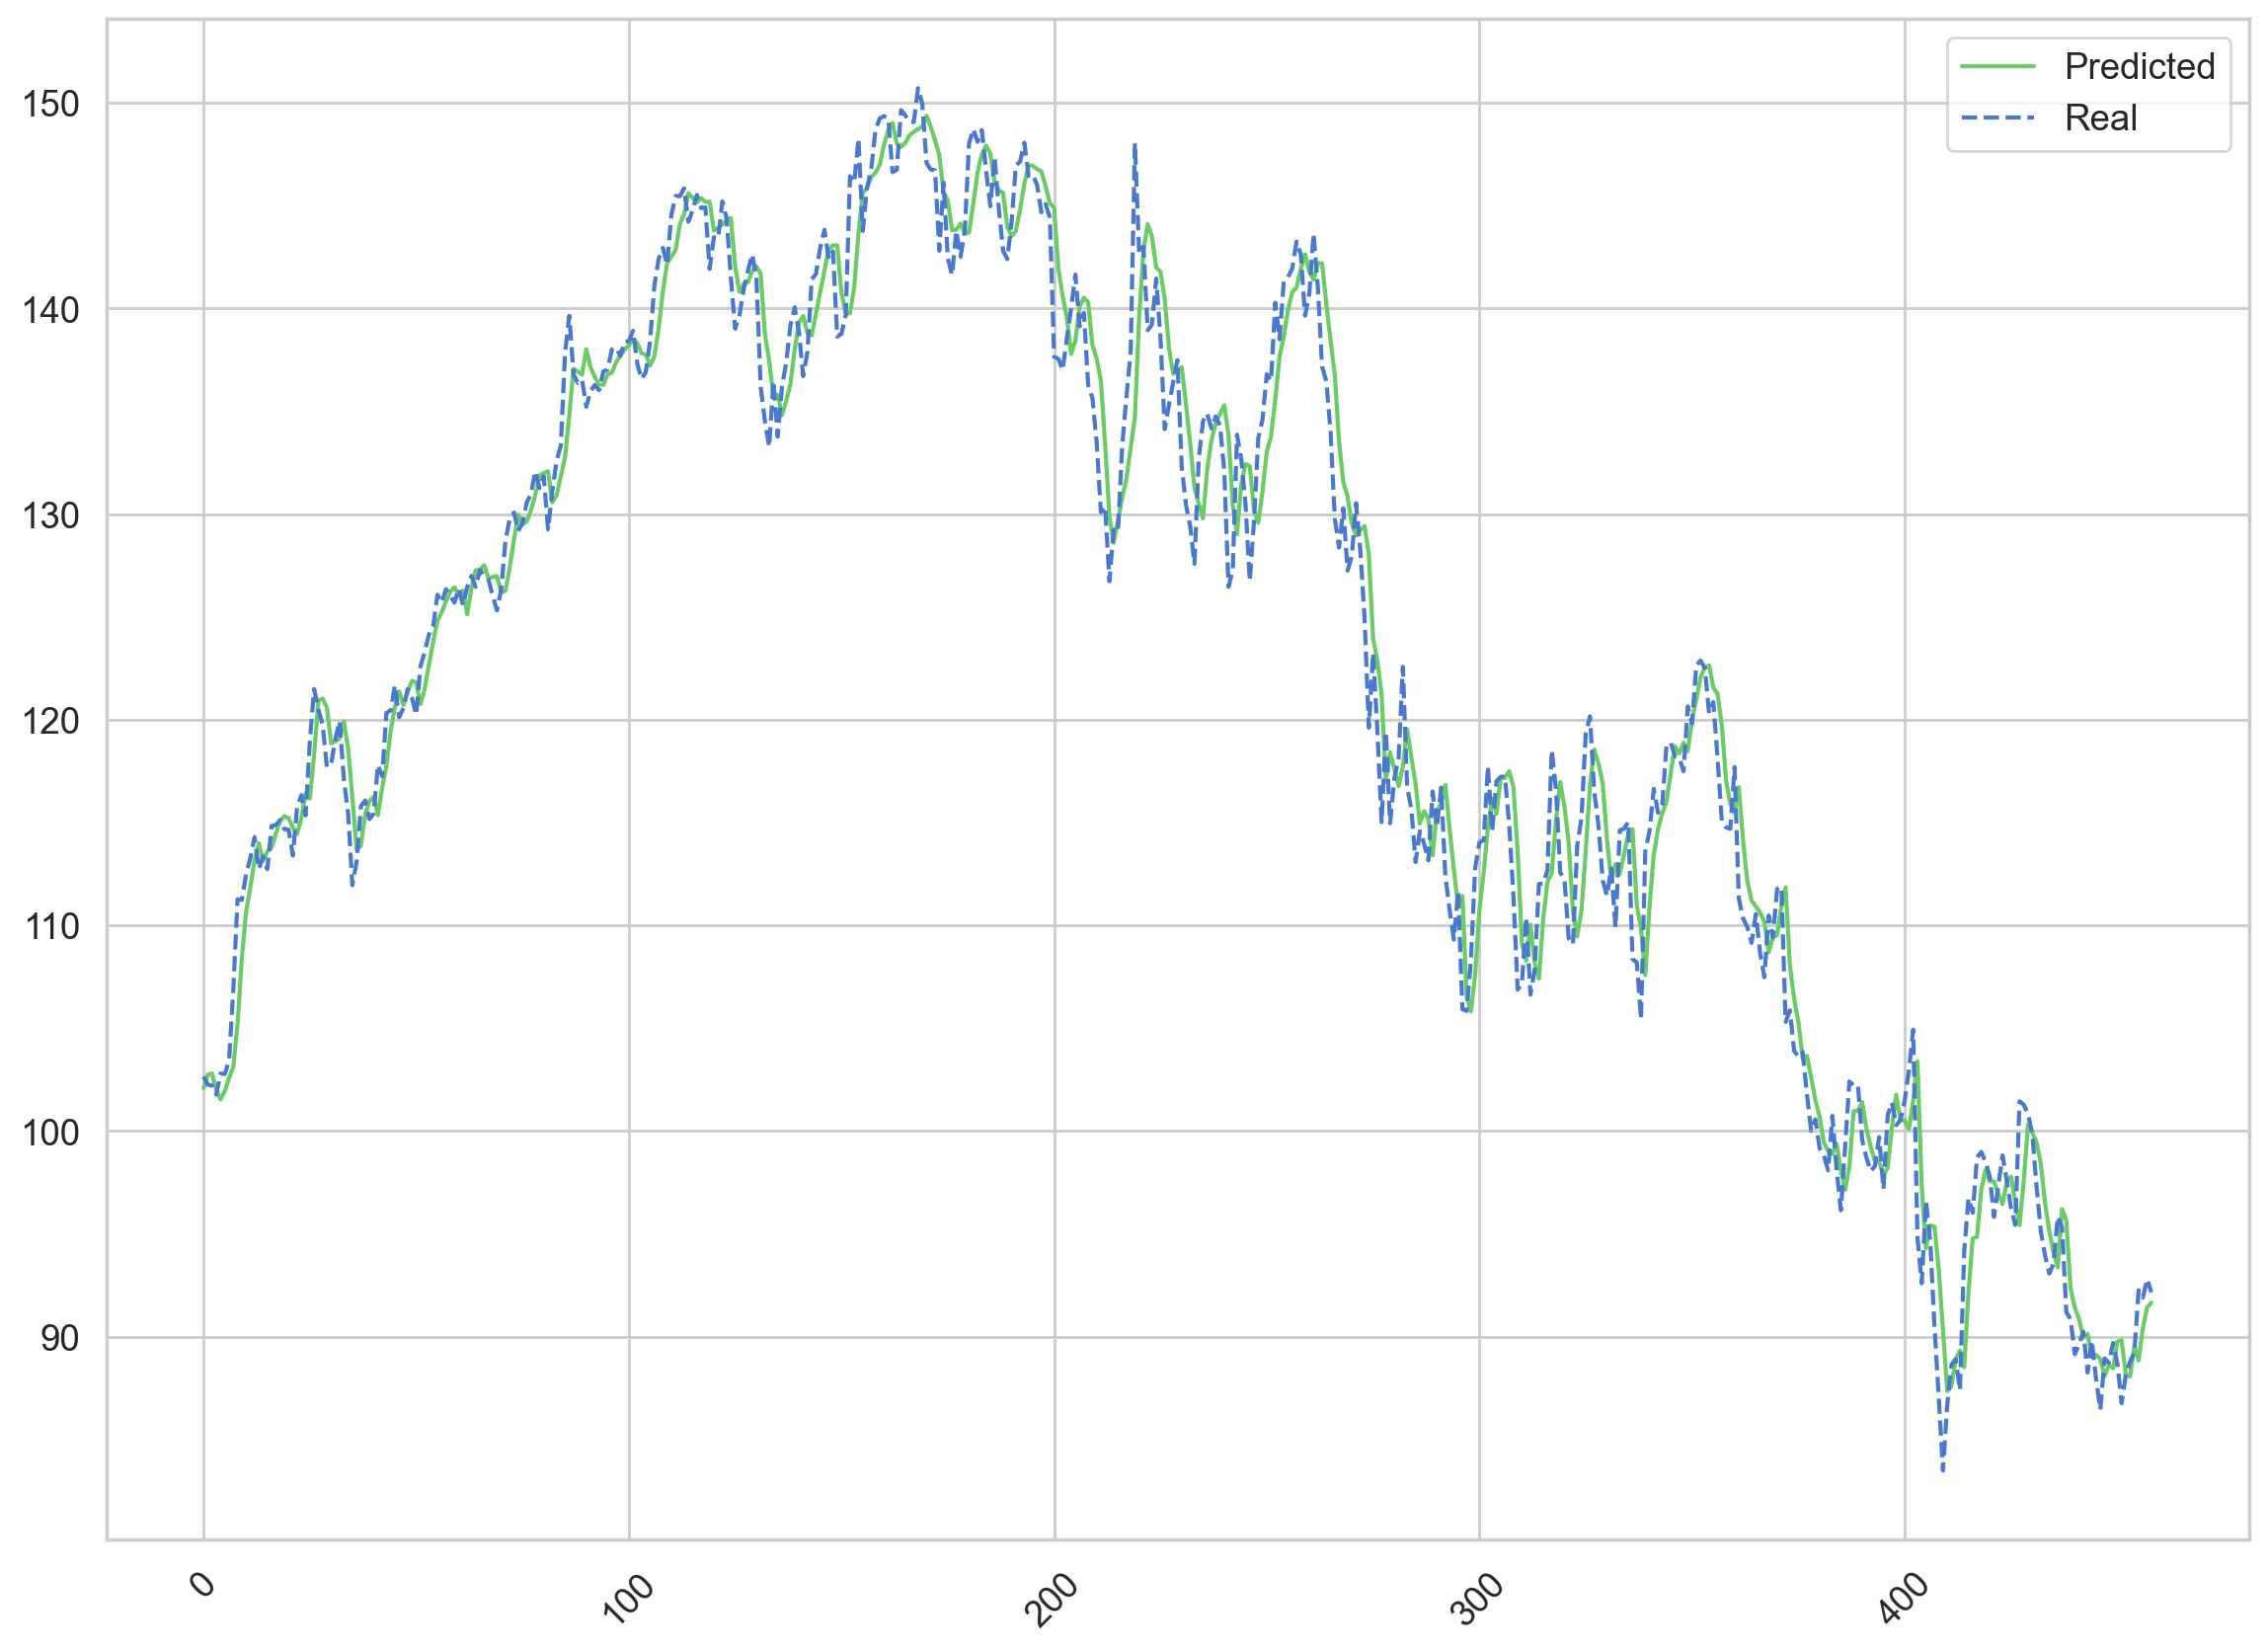

In [230]:
plt.plot(predictions_descaled, "-", label= "Predicted", color = "g")
plt.plot(labels_descaled, "--", label = "Real", color = "b")
plt.xticks(rotation =45)
plt.legend()
     

In [236]:
predictions_descaled

array([16.38352391, 16.03539599, 15.89207569, 16.02169823, 16.70429519,
       17.20135589, 17.57882017, 18.36808011, 18.30735099, 19.84523776,
       19.89507659, 20.2172627 , 19.95092496, 19.57922816, 19.66921709])

In [237]:
labels_descaled

array([15.75      , 16.200001  , 16.66999998, 17.55999906, 17.45999894,
       17.29000098, 18.49999999, 18.76999991, 20.5       , 19.99999993,
       19.95000114, 19.84999987, 19.719999  , 19.92000011, 19.62999903])